Versions:
* v1: one full cycle. Not yet multiple cycles implemented
* v2: MORDM cycle into IO-function
    * Can be used for MORDM validation
* v3: restructure into MORDM function
* v4: mpmordm iterative way - Finished
* v5: 
    * Micromodel between iterations
    * Distance table based on OSRM (not used in model, only for distances uncertainty
    * OSRM is not yet integrated in full process. just done once
* v6:
    * start: real distance matrix
    * then: real input data FLs
* v7: Verified that the mordm algorithmic function produces the same result as the decoupled version in MORDM v9 Model Testing
* v8: Nepal Data Full Run
* v9: Fixed bug: csv index numbers are now correct
* v10: Fixed bug: Changing information works correctly (typo in function, now checked)
* v11: New model (v9) and update uncertainty ranges for DSRFL and DSRDP
* v12: Increased effect uncertainty reduction


TODO inputdata: 
* parametrisation sigmoid and linear function

TODO model:


TODO:
* Priority: add singleextra location to non-dominated with highest information yield
* Priority: change info based on locations
* non-random disruption - for after MT?
* non-random uncertainty changes - for after MT?

TODO code:
* Clean foldernames and stuff. same foldername and subfolders based on case. casename/subfolders

# Imports

In [1]:
# Standard imports & printing versions
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Own Model import
from lib.fl_model_v9 import *
# import lib.fl_model_v5 as flm

# for natural sorting
import re

#for nondominated sorting
import lib.pareto as pareto
# from lib.list_imports import find_loaded_modules

# for parallel plotting
from lib.parallel_plotting import plot_optimal

# For checking ema running time
import time

import ema_workbench as ema
from ema_workbench.em_framework import (Policy, IntegerParameter, Constant,
                                        RealParameter, ScalarOutcome,
                                        perform_experiments, Model)
from ema_workbench import ema_logging
# from ema_workbench.em_framework.

ema_logging.log_to_stderr(ema_logging.INFO)

import sys

# for routing table:
import osrm

# For creation of disruption landscape: use vincenty for distance:
import geopy
from geopy.distance import great_circle

# for Plotting of Nepal
import folium

C:\Users\timro\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
# %load https://gist.github.com/TRomijn/d9d28ba7b7d5eeac1deea5a26dd326b2/raw/loaded_modules.py

'''
original author: kinverarity1

List loaded modules and packages, and show their version numbers
and/or Git repository's HEAD commit SHA.


Changes:
Minor changes to make compatible with Python 3
'''
# Standard library modules
import types
import os

# Third-party packages
import git      # GitPython


def module_path(mod):
    '''Returns path to the file that module *mod* comes from.
    If it doesn't come from a file, return None.'''
    if hasattr(mod, '__file__'):
        return os.path.abspath(os.path.dirname(mod.__file__))
    else:
        return None

    
def from_git_repo(mod):
    '''Does the module *mod* reside in a Git repository?'''
    path = module_path(mod)
    if path:
        try:
            repo = git.Repo(path)
        except:
            return False
        else:
            return True
    else:
        return False

    
def git_path_sha(mod, slice=slice(0, 8, 1)):
    '''Return SHA hash for the HEAD commit for the repository
    that the module *mod* resides in.'''
    repo = git.Repo(module_path(mod))
    return repo.git_dir, repo.head.commit.hexsha[:8]


def module_version(mod):
    '''Return version string for module *mod*, or nothing if
    it doesn't have a "version" or "__version__" attribute.'''
    version = []
    if hasattr(mod, '__dict__'):
        keys = []
        for key in mod.__dict__.keys():
            if key.lower() == 'version' or key.lower() == '__version__':
                v = mod.__dict__[key]
                if isinstance(v, str):
                    version.append(v)
        if keys:
            print (mod, keys)
    if version:
        return ', '.join(version)
    else:
        return ''

    
def find_loaded_modules(only_versioned_modules=True):
    '''Return list of loaded modules for which there is a version
    number or a Git repository commit SHA.
    
    Return a list of *(name, version, path_to_git_repo, git_head_sha)*,
    which has an HTML property for pretty display in IPython Notebooks.
        
    '''
    def list_of_lists_to_HTML(lists, header_row=None):
        '''Convert a list of a list of strings to a HTML table.'''
        s = '<table>'
        if header_row:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<th>%s</th>' % item for item in header_row])
            s += '\n\t</tr>'
        for inner_list in lists:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<td>%s</td>' % item for item in inner_list])
            s += '\n\t</tr>'
        s += '\n</table>'
        return s
    
    class LoadedModules(list):
        '''Very simple wrapper for a list of lists of strings, with an attribute
        for display in IPython Notebooks.'''
        def __init__(self, *args, **kwargs):
            list.__init__(self, *args, **kwargs)
            
        @property
        def HTML(self):
            from IPython.display import HTML
            return HTML(
                    list_of_lists_to_HTML(
                            self, header_row=['Name', 'Version', 'Path', 'SHA']))
                    
    objs = LoadedModules()
    for i, mod in enumerate(globals().values()):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__'):
                name = mod.__name__
            else:
                name = ''
            
            if from_git_repo(mod):
                path, sha = git_path_sha(mod)
            else:
                path = ''
                sha = ''
            
            version = module_version(mod)
            
            if only_versioned_modules:
                flag = version or (path and sha)
            else:
                flag = True
            
            if flag:
                objs.append([mod.__name__, version, path, sha])
    objs.sort(key=lambda r: r[0])
    return objs


    
    

In [3]:
find_loaded_modules().HTML

Name,Version,Path,SHA
ema_workbench,1.1.3,,
folium,0.5.0,,
geopy,1.13.0,,
git,2.1.9,,
json,2.0.9,,
lib.pareto,1.1.1-3,,
numpy,1.14.2,,
osrm,0.11.1,,
pandas,0.23.0,,
re,2.2.1,,


# Set Meta Data

In [4]:
case = "Nepal"
output_folder = "MPMORDM Results v1 2015"
# output_folder = "Output_testing5"

# Load Prepared Data

In [5]:
DPs = pd.read_csv("{}/Prepared Input Data/DPs.csv".format(case))
DPs.columns

Index(['name', 'population', 'latitude', 'longitude'], dtype='object')

In [6]:
FLs = pd.read_csv("{}/Prepared Input Data/FLs.csv".format(case))
FLs.columns

Index(['Name', 'Lat', 'Lon'], dtype='object')

In [7]:
SPs = pd.read_csv("{}/Prepared Input Data/SPs.csv".format(case))
SPs.columns

Index(['name', 'latitude_deg', 'longitude_deg'], dtype='object')

In [8]:
# Routing Table for changing information based on distance
# time_matrix
time_matrix = pd.read_csv("{}/Prepared Input Data/routing_table.csv".format(case))
nodes = time_matrix.columns
time_matrix.index = nodes

## Prepare Data for model input

### Global: Fixed certain data

In [9]:
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(DPs['latitude'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(DPs['longitude'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(SPs['latitude_deg'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(SPs['longitude_deg'])}

# Facility locations
FLX = {"FLX{}".format(i): x for i,x in enumerate(FLs['Lon'])}
FLY = {"FLY{}".format(i): y for i,y in enumerate(FLs['Lat'])}

# Population demand points
DPpop = {"DPpop{}".format(i): pop for i,pop in enumerate(DPs['population'])}

### Global: Fixed uncertain data

In [10]:
print("Warning: use the right table. difference for FL range in different csv files")

In [11]:
global_fixed_unc = pd.read_csv("{}/Prepared Input Data/fixed_uncertainties.csv".format(case)).set_index('var')

### Variable Uncertain Data: generate random for now:
DFs becomes a global. can be accessed by using its label

In [12]:
# # TODO: Base real values on Nepal earthquake
# # DSR = Disruption
# DSRDP = {"DSRDP{}".format(i): random.uniform (1, 2) for i in range(len(DPX))}
# DSRFL = {"DSRFL{}".format(i): random.uniform (1, 2) for i in range(len(FLX))}


#### Use radial function to determine disruption value

In [13]:
epicentre_name = "RealLocation"

In [14]:
disruptionsFLs = np.loadtxt(
    'Nepal/Prepared Input Data/DisruptionFL{}.txt'.format(epicentre_name))
disruptionsDPs = np.loadtxt(
    'Nepal/Prepared Input Data/DisruptionDP{}.txt'.format(epicentre_name))

In [15]:
# Base real values on Nepal earthquake
# DSR is abbreviation for Disruption

DSRDP = {"DSRDP{}".format(i): disruptionsDPs[i] for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): disruptionsFLs[i] for i in range(len(FLX))}

In [16]:
DSRFL

{'DSRFL0': 1.9,
 'DSRFL1': 1.489494393457016,
 'DSRFL2': 1.1866162616386002,
 'DSRFL3': 1.4574384957321447,
 'DSRFL4': 1.8792363114331099,
 'DSRFL5': 1.3914168177477082,
 'DSRFL6': 1.1,
 'DSRFL7': 1.3539717546272372,
 'DSRFL8': 1.2093425072870079,
 'DSRFL9': 1.8224003392347439,
 'DSRFL10': 1.8584238186595268,
 'DSRFL11': 1.3240969900040098,
 'DSRFL12': 1.7281742675436205,
 'DSRFL13': 1.431493047403166,
 'DSRFL14': 1.4558777058102628,
 'DSRFL15': 1.3442003933093274,
 'DSRFL16': 1.4698893797656103,
 'DSRFL17': 1.4552683230160328,
 'DSRFL18': 1.121665437300933,
 'DSRFL19': 1.1972298498924403}

#### plot different options

|Priority| Scenario | Epicentre | Min impact | Max impact |
|---| --- | --- | --- | --- |
|3| 2015 Earthquake | 28.14, 84.70 | 1 | 2 |
|1| Heavy West Earthquake (fictional) | 29.06, 81.82 | 1 | 2 |
|1| Heavy East Earthquake (fictional) | 27.14, 87.12 | 1 | 2 |
|2| Light West Earthquake (fictional) | 29.06, 81.82 | 1 | 1.5 |
|2| Light East Earthquake (fictional) | 27.14, 87.12 | 1 | 1.5 |

source 2015 earthquake epicentre:<br>
http://www.gdacs.org/Earthquakes/report_shakemap.aspx?eventid=1052901&shakeid=1&eventtype=EQ


In [17]:
# map_epic = [[29, 82],[27.2,86.5], [28.14,84.7]]
# # map_circle_dists = [50000,200000,400000]
# # map_circle_colors = ["red","orange","yellow"]
# map_circle_dists = [50000,]
# map_circle_colors = ["red",]

# map_nepal = folium.Map(location=[28, 84.5], zoom_start=6)

# for i in range(len(map_circle_colors)):
#     folium.Circle(
#         radius=map_circle_dists[i],
#         location=map_epic[0],
#         color=map_circle_colors[i],
#     ).add_to(map_nepal)
    
# for i in range(len(map_circle_colors)):
#     folium.Circle(
#         radius=map_circle_dists[i],
#         location=map_epic[1],
#         color=map_circle_colors[i],
#     ).add_to(map_nepal)
    
# for i in range(len(map_circle_colors)):
#     folium.Circle(
#         radius=map_circle_dists[i],
#         location=map_epic[2],
#         color=map_circle_colors[i],
#     ).add_to(map_nepal)

# print("Epicentres")
# map_nepal


### Sth

In [18]:
# label each branch. start with:
start_label = "p0n0"
# Each branch has a separate perception of what the data is.
# A dictionary can keep track of data for each branch, linked via label
global_dfs_var_unc_data = {}

In [19]:
global_dfs_var_unc_data [start_label] = pd.DataFrame.from_dict({**DSRDP, **DSRFL}, orient='index')

In [20]:
global_dfs_var_unc_data [start_label].head(1)

,0
DSRDP0,1.520303


In [21]:
# create upper and lower bound

global_dfs_var_unc_data[start_label] = global_dfs_var_unc_data[
    start_label].rename(columns={0: "actual"})

global_dfs_var_unc_data[start_label]['lower'] = 1
global_dfs_var_unc_data[start_label]['upper'] = 2
global_dfs_var_unc_data[start_label]['best_estimate'] = (
    global_dfs_var_unc_data[start_label]['upper'] +
    global_dfs_var_unc_data[start_label]['lower']) / 2
# global_dfs_var_unc_data[start_label][
#     'difference'] = global_dfs_var_unc_data[start_label]['best_estimate'] - global_dfs_var_unc_data[start_label]['actual']
global_dfs_var_unc_data[start_label].head()

,actual,lower,upper,best_estimate
DSRDP0,1.520303,1,2,1.5
DSRDP1,1.290710,1,2,1.5
DSRDP2,1.520151,1,2,1.5
DSRDP3,1.900000,1,2,1.5
DSRDP4,1.494693,1,2,1.5


In [22]:
global_dfs_var_unc_data.keys()

dict_keys(['p0n0'])

### Other Globals:
- Create Starting situation policies:
- List of all Models

# MORDM

## Helper functions

In [23]:
def create_policies(FL_dict, print_pols=False):
    """
    Takes the current network of Facility Locations and returns all possible policies for one added FL.
    
    Input: current option (Dict of FLs)
    Output: List of options (Dicts of FLs)
    
    Printing module not completely reliable. doesnt print whats actually in thereTODO
    """

    def natural_key(string_):
        return [
            int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)
        ]

    # All FL names
    FL_keys = sorted(FL_dict.keys(), key=natural_key)
    # All FL values indicating whether operational
    FL_values = [FL_dict[key] for key in FL_keys]

    i_operational_fls = i_FL_op = [
        i for i, x in enumerate(FL_values) if x == 1
    ]

    # Create list of policies
    pols = np.identity(len(FL_keys))
    # Set already operational facilities to operational
    pols[:, i_operational_fls] = 1

    #Delete policies where no new FLs are placed
    new_n_operational_fls = sum(FL_values) + 1
    pols = pols[pols.sum(axis=1) == new_n_operational_fls]

    # Return a list of dictionaries
    policy_list = []
    for pol in pols:
        policy_list.append({key: value for key, value in zip(FL_keys, pol)})

    if print_pols == True:
        print("total policies:", len(policy_list))
        for n, i in enumerate(policy_list):
            for v in i.values():
                print(int(v), end='')
            print(" <- policy {}".format(n))

    return policy_list


def calculate_signalNoise(data, obj):
    '''
    data : 1d array, the values of an outcome indicator for a policy
    obj  : the objective corresponding to an outcome indicator, 1 or -1
    '''
    if obj == -1:  #MINIMIZE
        score = (np.mean(data) + 1) * (
            np.std(data) + 1
        )  #to avoid division by zero if the std. deviation is zero, we can add 1.
    elif obj == 1:  #MAXIMIZE
        score = (np.mean(data) + 1) / (np.std(data) + 1)
    return score


def calculate_maxregret(data, obj):
    '''
    data : a list of 1d arrays whose shape is no_policies x no_scenarios
    obj : -1 or 1, the objective 
    '''
    data = np.array(data)
    if obj == 1:  #MAXIMIZE
        #find the best case in each scenario, therefore use the max function of numpy on the axis of policies
        zero_regrets = np.max(data, axis=0)
    elif obj == -1:  #MINIMIZE
        zero_regrets = np.min(data, axis=0)

    #determine the regret values for eaxh policy in each scenario
    regrets = [
        abs(np.subtract(data[p], zero_regrets)) for p in range(data.shape[0])
    ]

    max_regrets = np.max(regrets, axis=1)

    return max_regrets


## Main

MORDM function should be defined within main script, because it uses global files

In [24]:
"""
Many-Objective Robust Decision-Making Algorithm
Specifically implemented to be consistent with the FL model
"""

def MORDM(current=None,
          current_period=None,
          trace_label=None,
          n_scenarios=100,
          table_dir="prespecify routing table.csv",
          saving_dir="prespecify this dir/",
          additional_info=None,
          show_MORDM_graphics=False,
          show_model_graphics=False):
    """
    current: indexes of current operational locations
    trace_label: label of input node
    fixed_data: 
    var_data: df of variable data for each 
    max_depth: maximum number of total FLS
    """

    if show_MORDM_graphics == True:
        raise NotImplementedError("""visualisations are not implemented (yet). 
            Not sure yet if impementing graphics in MPMORDM is usefull for every period """
                                  )

    #Start Many Objective Optimisation
    #best estimate values
    best_estimate_disruptions = {
        i: be
        for be, i in zip(global_dfs_var_unc_data[trace_label]['best_estimate'],
                         global_dfs_var_unc_data[trace_label].index)
    }
    
    # create list of already operational FLS
    current_fls = [fl for fl in current.keys() if current[fl] == 1]
    # Create new policies
    optional_policies = create_policies(current, print_pols=False)
    # Create list of new optional FLS, without the already operational FLS
    optional_fls = [[key for key in dic.keys() if dic[key] == 1 and key not in current_fls] for dic in optional_policies]
    # Flatten and take only integers
    optional_fls = np.array([int(item[3:]) for sublist in optional_fls for item in sublist])
    # Check
    if len(optional_fls) != len (optional_policies):
        print("Warning2! Something not right")

    #evaluate all policies
    best_est_results_opt_pols = []
    for policy in optional_policies:
        best_est_results_opt_pols.append(
            FL_model(
                unit_opening_costs=global_fixed_unc.loc["unit_opening_costs",
                                                        "best_estimate"],
                unit_transport_cost=global_fixed_unc.loc["unit_transport_cost",
                                                         "best_estimate"],
                FL_operations_cost=global_fixed_unc.loc["FL_operations_cost",
                                                        "best_estimate"],
                graphical_representation=show_model_graphics,
                FL_range=global_fixed_unc.loc["FL_range",
                                              "best_estimate"],  # km? --> m
                dist_method="from_table",
                table_dir=table_dir,
                demand_per_affected=global_fixed_unc.loc[
                    "demand_per_affected", "best_estimate"],  #km/u? --> m/s
                # fixed certain
                **SPX,
                **SPY,
                **DPX,
                **DPY,
                **FLX,
                **FLY,
                **DPpop,
                # specific
                **policy,
                **best_estimate_disruptions))

    if len(best_est_results_opt_pols) == 0:
        raise ValueError(
            "No results found in many-objective optimisation (before constraint)"
        )
    #constraint 1:
    #Filter out those where not all operational FLs provide supplies to DPs


#     best_est_results_opt_pols2 = [pol for pol in best_est_results_opt_pols if pol[-1] == True]

# outcome indicators, as internally used by the model
    oois = [
        'total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand',
        'max_distr_time'
    ]
    # Put outcomes in DF
    df_best_est_results_opt_pols = pd.DataFrame(
        np.asarray(best_est_results_opt_pols)[:, :5],
        columns=oois + ["constraint1"])

    # Filter out based on constraint1
    df_best_est_results_opt_pols = df_best_est_results_opt_pols[
        df_best_est_results_opt_pols.constraint1 == 1]
    # remove constraint label
    df_best_est_results_opt_pols = df_best_est_results_opt_pols[oois]

    # print("move this somewhere else TODO")
    # print("XXX", df_best_est_results_opt_pols.shape)
    if df_best_est_results_opt_pols.shape[0] == 0:
        raise ValueError(
            "No results found in many-objective optimisation that satisfy constraints \n probably wrong FL_range"
        )

    #nondominated sorting
    nondominated_BE_policy_results = np.array(
        pareto.eps_sort(
            [list(df_best_est_results_opt_pols.itertuples(index=True))],
            [1, 2, 3, 4], [1e-9, 1e-9, 1e-9, 1e-9]))


    #put nondominated policies in array
    nondom_i = [int(a[0]) for a in nondominated_BE_policy_results]
    nondominated_BE_policies = np.array(optional_policies)[nondom_i]
    nondom_fls = optional_fls[nondom_i]
    
    df_nondom_BE_pols = pd.DataFrame(
        nondominated_BE_policy_results, columns=["i"] + oois).set_index("i")
    # Give FL numbers as correct index
    df_nondom_BE_pols.index = nondom_fls
    
    df_nondom_BE_pols.to_csv(
        saving_dir + "nondom_BE_pols{}.csv".format(trace_label))

    #End Many Objective Optimisation
    #Start Robustness analysis

    EMA_model_dict[trace_label] = Model("flmodel{}".format(trace_label),
                                        FL_model)

    EMA_model_dict[trace_label].locations = [
        Constant("DPX{}".format(i), x)
        for i, x in zip(DPs.index, DPs['longitude'])
    ] + [
        Constant("DPY{}".format(i), y)
        for i, y in zip(DPs.index, DPs['latitude'])
    ] + [
        Constant("SPX{}".format(i), x)
        for i, x in zip(SPs.index, SPs['longitude_deg'])
    ] + [
        Constant("SPY{}".format(i), y)
        for i, y in zip(SPs.index, SPs['latitude_deg'])
    ] + [
        Constant("FLX{}".format(i), x) for i, x in zip(FLs.index, FLs['Lon'])
    ] + [
        Constant("FLY{}".format(i), y) for i, y in zip(FLs.index, FLs['Lat'])
    ]

    # model.locations_uncertain =   [
    #     RealParameter("FLX{}".format(i), DPs['Longitude (DD)'].min(), DPs['Longitude (DD)'].max()) for i in range(nr_of_FLs)
    # ] + [RealParameter("FLY{}".format(i), DPs['Latitude (DD)'].min(), DPs['Latitude (DD)'].max()) for i in range(nr_of_FLs)]

    EMA_model_dict[trace_label].constants = [
        Constant('graphical_representation', False),
        Constant('dist_method', 'from_table'),
        Constant('Error_Test', 1),  # this doesn't do anything. 
        #list of other constants
        Constant('table_dir', table_dir)
    ] + EMA_model_dict[trace_label].locations + [  # population DPs
        Constant("DPpop{}".format(i), pop)
        for i, pop in zip(DPs.index, DPs['population'])
    ]

    # Reachability of Demand Points and Facility Locations can be disrupted
    # Disruption also determines demand (disr-1)*pop
    EMA_model_dict[trace_label].disruptions = [
        RealParameter(i, l, u) for i, l, u in zip(global_dfs_var_unc_data[
            trace_label].index, global_dfs_var_unc_data[trace_label][
                'lower'], global_dfs_var_unc_data[trace_label]['upper'])
    ]

    EMA_model_dict[trace_label].uncertainties = [
        RealParameter(i, l, u)
        for i, l, u in zip(global_fixed_unc.index, global_fixed_unc.lower,
                           global_fixed_unc.upper)
    ] + EMA_model_dict[trace_label].disruptions  #+ model.locations_uncertain

    EMA_model_dict[trace_label].outcomes = [
        ScalarOutcome("total_costs", kind=ScalarOutcome.MINIMIZE),
        ScalarOutcome("nr_uncovered_DPs", kind=ScalarOutcome.MINIMIZE),
        ScalarOutcome("total_uncovered_demand", kind=ScalarOutcome.MINIMIZE),
        ScalarOutcome(
            "max_distr_time",
            kind=ScalarOutcome.MINIMIZE,
        )
    ]

    if [o.name for o in EMA_model_dict[trace_label].outcomes] != oois:
        print("Watch out! Oois and model outcome names are not similar!")

    nondominated_BE_policies_EMA = []
    for name, pol in zip(nondom_i, nondominated_BE_policies):
        nondominated_BE_policies_EMA.append(Policy("{}".format(name), **pol))

    time1 = time.time()
    all_scen_results_nondom_pols = perform_experiments(
        EMA_model_dict[trace_label], n_scenarios, nondominated_BE_policies_EMA)
    time2 = time.time()
    print("Total time:{}".format(time2 - time1), "\n",
          "time per run = {}".format(
              (time2 - time1) /
              (n_scenarios * len(nondominated_BE_policies_EMA))))

    ema.save_results(all_scen_results_nondom_pols,
                     saving_dir + "{}.tar.gz".format(trace_label))
    experiments, outcomes = all_scen_results_nondom_pols

    sigN_results = []

    for policy in nondominated_BE_policies_EMA:
        #filter the outcome values corresponding to each policy using a logical index
        logical_index = experiments['policy'] == policy.name
        # If ever something goes wrong here, probably add: int() to policy.name
        pol_outcomes = {
            key: outcomes[key][logical_index]
            for key in outcomes.keys()
        }
        temp_result = {}
        for ooi in EMA_model_dict[trace_label].outcomes:
            temp_result[ooi.name] = calculate_signalNoise(
                pol_outcomes[ooi.name], ooi.kind)
        sigN_results.append(temp_result)

    df_sigN = pd.DataFrame(
        sigN_results, index=[pol.name for pol in nondominated_BE_policies_EMA])

    reg_results = {}
    # we need to iterate over the outcomes differently now,
    #because the maximum egret calculation requires the outcome values for all policies
    for ooi in EMA_model_dict[trace_label].outcomes:
        data = []
        for policy in nondominated_BE_policies_EMA:
            logical_index = experiments['policy'] == policy.name
            # If ever something goes wrong here, add int() to policy.name
            data.append(outcomes[ooi.name][logical_index])
        reg_results[ooi.name] = calculate_maxregret(data, ooi.kind)
    df_regret = pd.DataFrame.from_dict(
        reg_results,
        orient='columns',
    )
    df_regret.index = [pol.name for pol in nondominated_BE_policies_EMA]

    all_robustness_scores = pd.merge(
        df_regret,
        df_sigN,
        left_index=True,
        right_index=True,
        suffixes=("_regret", "_sigN"))

    robust_nondominated_policies = pareto.eps_sort(
        [list(all_robustness_scores.itertuples(index=True))],
        [i + 1 for i in range(all_robustness_scores.shape[1])],
        [1e-9] * all_robustness_scores.shape[1])

    if len(robust_nondominated_policies) == 0:
        print("something went wrong")
    elif len(robust_nondominated_policies) == 1:
        print("no branching, only a single nondominated robust location")
        temp_cols = ["pol_i"] + list(all_robustness_scores.columns)

        df_rob_nondom_pols = pd.DataFrame(
            robust_nondominated_policies, columns=temp_cols).set_index("pol_i")
    #     print(robust_nondominated_policies)
    else:
        temp_cols = ["pol_i"] + list(all_robustness_scores.columns)
        df_rob_nondom_pols = pd.DataFrame(
            robust_nondominated_policies, columns=temp_cols).set_index("pol_i")

    nondom_rob_fls = optional_fls[list(df_rob_nondom_pols.index.astype(int))]
    
    rob_nondom_i = [int(i) for i in df_rob_nondom_pols.index]
    
    df_rob_nondom_pols.index = nondom_rob_fls
    df_rob_nondom_pols.to_csv(
        saving_dir + "nondom_rob_pols{}.csv".format(trace_label))


    return np.array(optional_policies)[rob_nondom_i]

## Testing single cycle

TODO: save csv nondom pols + csv rob nondom pols
possible: clear op variable space with del

In [25]:
# EMA_model_dict = {}

In [26]:
# start_situation = {key: 0 for key in FLs.Name}
# test = MORDM(
#     current=start_situation,
#     n_scenarios=1000,
#     trace_label=start_label,
#     table_dir="{}/Prepared Input Data/routing_table.csv".format(case),
#     saving_dir="{}/{}/".format(case,output_folder))

In [27]:
# for i in test:
#     a = (i.items())
# #     print (a)
#     for b in a:
#         if b[1] == 1:
#             print (b)
# #         break
# #     break
    

# Full cycle

In [28]:
global_dfs_var_unc_data.keys()

dict_keys(['p0n0'])

Now first: label management

#### define and plot sigmoid and linear funtion

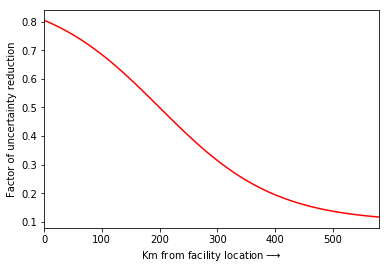

not yet adjusted for travel times instead of distances


In [29]:
sig_min = 0.1
sig_height = 0.9 - sig_min 
sig_length = 200 # TODO should be more or less equal to expected max_cov distance. 
sig_steepness = -0.01#steepness chosen arbitrarily to create nice curve

sigmoid = lambda x: sig_height / (1 + np.exp(- sig_steepness*(x-sig_length))) + sig_min
# x=np.linspace(0,10,10)
y=np.linspace(0,sig_length*3,100)
plt.plot(y,sigmoid(y),'r')
plt.xlabel(r'Km from facility location$\longrightarrow$')
plt.ylabel("Factor of uncertainty reduction")
plt.xlim((0,sig_length*2.9))
plt.show()
print("not yet adjusted for travel times instead of distances")

In [30]:

def linear(x, dist_max, depth=0.1, height=0.5, plotting=False):
    """
    dist: max distance that yields new info
    height: max percentage of new info
    """
    if plotting == False:
        return max(min(height - (height/dist_max) * x,height),depth)
    if plotting == True:
        return [max(min(height - ((height-depth)/(dist_max)) * y,height),depth) for y in x]


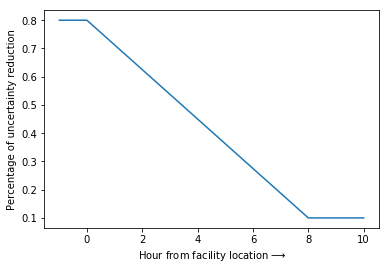

make sure that all units etc. are right: km,s,hours,etc,etc


In [31]:
x=np.linspace(-1,10,100)
plt.plot(x,linear(x, 8,height=0.8,plotting=True))
plt.xlabel(r'Hour from facility location$\longrightarrow$')
plt.ylabel("Percentage of uncertainty reduction")
# plt.xlim((0,sig_length*2.9))
plt.show()
print("make sure that all units etc. are right: km,s,hours,etc,etc")

#### Micromodel changing uncertainty space

##### TODO: Describe and formalise in report
XX TODO: Parametrisation of distance
uncertainty reduction

In [32]:
def new_est_low_up(row, fl_n, method="linear", lin_max_dist = 8):
    """
    method: linear or sigmoid
    XXTODO: check params for sigmoid&linear function XXTODO
    Validated"""
    row_label = row.name[3:]
    fl_label = "FL{}".format(fl_n)
    dist = time_matrix.loc[fl_label, row_label]
    if method == "linear":

        unc_red = linear(dist/3600, lin_max_dist, height=0.8)
#         print(unc_red)
    if method == "sigmoid":

        unc_red == sigmoid (dist/3600)
    be_new = row['best_estimate'] + (row['actual']-row['best_estimate'])* unc_red
    low_new = be_new - 0.5 * (row['upper']-row['lower']) * (1-unc_red)
    up_new = be_new + 0.5 * (row['upper']-row['lower']) * (1-unc_red)
    return low_new, be_new, up_new

In [33]:
def change_decision_based_uncertainty(df, fls_dict):
    """
    input: current df, integer operational FLs
    returns changed dataframe
    """ 
    fls = [int(key[3:]) for key,val in fls_dict.items() if val == 1]
    
    df2 = df.copy(deep=True)
    for fl in fls:
        print(fl,type(fl))
        df2['lower'], df2['best_estimate'], df2['upper'] = zip(
            *df2.apply(lambda row: new_est_low_up(row, fl), axis=1))
    return df2


# df3 = change_decision_based_uncertainty(df_test, [2, 3])

In [34]:
periods = 4  # 1 location per period -> locations = periods

global_node_counter = 0

start_situation = {key: 0 for key in FLs.Name}
global_policy_tree = {start_label: start_situation}
global_label_tree = {
    "p{}".format(p, global_node_counter): []
    if p != 0 else ["{}".format(start_label)]
    for p in range(periods + 1)
}

EMA_model_dict = {}  # XX somewhere else: global
print("starting label:", start_label)

for p in range(periods):
    for node_i, node in enumerate(list(global_label_tree["p{}".format(p)])):
        #         print("|", p, node)
        if p < periods:
            print("Do mordm, in period:", p, "label:", node, "policy:",
                  global_policy_tree[node])
            #             new_pols = ["a", "b", "c"]
            new_pols = MORDM(
                current=global_policy_tree[node],
                n_scenarios=500,
                trace_label=node,
                table_dir="{}/Prepared Input Data/routing_table.csv".format(case),
                saving_dir="{}/{}/".format(case, output_folder))
            for new_pol in new_pols:
                # Create new label
                global_node_counter += 1
                new_label = node + "p{}n{}".format(p + 1, global_node_counter)
                print("result:|||", new_label)
                # Create new branch
                global_label_tree["p{}".format(p + 1)].append(new_label)
                # add new policy
                global_policy_tree[new_label] = new_pol
                # change information based on policy
                #TODO not implemented yet
                #                 global_dfs_var_unc_data[new_label] = global_dfs_var_unc_data[start_label]
                print(new_pol)
                #change uncertainty based on new policy implementations
                global_dfs_var_unc_data[
                    new_label] = change_decision_based_uncertainty(
                        global_dfs_var_unc_data[node], new_pol)

        else:
            print(p, "if you see this, sth went wrong.")

#     print("__end_period:",p)

starting label: p0n0
Do mordm, in period: 0 label: p0n0 policy: {'FLO0': 0, 'FLO1': 0, 'FLO2': 0, 'FLO3': 0, 'FLO4': 0, 'FLO5': 0, 'FLO6': 0, 'FLO7': 0, 'FLO8': 0, 'FLO9': 0, 'FLO10': 0, 'FLO11': 0, 'FLO12': 0, 'FLO13': 0, 'FLO14': 0, 'FLO15': 0, 'FLO16': 0, 'FLO17': 0, 'FLO18': 0, 'FLO19': 0}


[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:50.585089445114136 
 time per run = 0.012646272361278533


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0.tar.gz


result:||| p0n0p1n1
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
result:||| p0n0p1n2
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
result:||| p0n0p1n3
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
11 <class 'int'>
result:||| p0n0p1n4
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:36.42618274688721 
 time per run = 0.012142060915629069


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1.tar.gz


result:||| p0n0p1n1p2n8
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
4 <class 'int'>
7 <class 'int'>
result:||| p0n0p1n1p2n9
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n10
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
13 <class 'int'>
result:||| p0n0p

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.102508544921875 
 time per run = 0.011367502848307292


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2.tar.gz


result:||| p0n0p1n2p2n14
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
result:||| p0n0p1n2p2n15
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n2p2n16
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
16 <class 'int'>
result:||| p0n

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:45.225154399871826 
 time per run = 0.011306288599967957


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3.tar.gz


result:||| p0n0p1n3p2n18
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n19
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n20
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
result:||| p0

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:50.44152307510376 
 time per run = 0.011209227350023058


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4.tar.gz


result:||| p0n0p1n4p2n25
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
13 <class 'int'>
result:||| p0

[MainProcess/INFO] performing 500 scenarios * 11 policies * 1 model(s) = 5500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 550 cases completed
[MainProcess/INFO] 1100 cases completed
[MainProcess/INFO] 1650 cases completed
[MainProcess/INFO] 2200 cases completed
[MainProcess/INFO] 2750 cases completed
[MainProcess/INFO] 3300 cases completed
[MainProcess/INFO] 3850 cases completed
[MainProcess/INFO] 4400 cases completed
[MainProcess/INFO] 4950 cases completed
[MainProcess/INFO] 5500 cases completed
[MainProcess/INFO] experiments finished


Total time:61.70373797416687 
 time per run = 0.011218861449848521


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5.tar.gz


result:||| p0n0p1n5p2n32
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
14 <class 'int'>
result:||| p0

[MainProcess/INFO] performing 500 scenarios * 10 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] experiments finished


Total time:57.053393840789795 
 time per run = 0.01141067876815796


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6.tar.gz


result:||| p0n0p1n6p2n41
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n42
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n43
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
11 <class 'int'>
16 <class 'int'>
result:||| p

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.4583101272583 
 time per run = 0.011486103375752767


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7.tar.gz


result:||| p0n0p1n7p2n48
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n49
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n50
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
13 <class 'int'>
19 <class 'int'>
result:|||

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.767558336257935 
 time per run = 0.011507023334503173


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n8.tar.gz


result:||| p0n0p1n1p2n8p3n53
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
4 <class 'int'>
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n8p3n54
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
4 <class 'int'>
7 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n8p3n55
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
4 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.097513914108276 
 time per run = 0.011365837971369426


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n9.tar.gz


result:||| p0n0p1n1p2n9p3n58
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n9p3n59
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n9p3n60
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.2804069519043 
 time per run = 0.011426802317301431


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n10.tar.gz


result:||| p0n0p1n1p2n10p3n63
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n10p3n64
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n10p3n65
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:52.00938963890076 
 time per run = 0.011557642141977947


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n11.tar.gz


result:||| p0n0p1n1p2n11p3n68
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n11p3n69
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n11p3n70
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:45.62792348861694 
 time per run = 0.011406980872154237


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n12.tar.gz


result:||| p0n0p1n1p2n12p3n75
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n12p3n76
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n12p3n77
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.23643469810486 
 time per run = 0.011412144899368286


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n13.tar.gz


result:||| p0n0p1n1p2n13p3n80
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n13p3n81
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n13p3n82
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.759104013442993 
 time per run = 0.011503641605377197


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n14.tar.gz


result:||| p0n0p1n2p2n14p3n85
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n2p2n14p3n86
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n2p2n14p3n87
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:44.2577064037323 
 time per run = 0.011064426600933075


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n15.tar.gz


result:||| p0n0p1n2p2n15p3n89
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n2p2n15p3n90
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n2p2n15p3n91
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.79768347740173 
 time per run = 0.011265894492467244


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n16.tar.gz


result:||| p0n0p1n2p2n16p3n95
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n2p2n16p3n96
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n2p2n16p3n97
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.16361737251282 
 time per run = 0.01118960496357509


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n17.tar.gz


result:||| p0n0p1n2p2n17p3n100
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n17p3n101
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
8 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n17p3n102
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.71279501914978 
 time per run = 0.011237598339716593


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n18.tar.gz


result:||| p0n0p1n3p2n18p3n105
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
3 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n18p3n106
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n18p3n107
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:45.21118688583374 
 time per run = 0.011302796721458435


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n19.tar.gz


result:||| p0n0p1n3p2n19p3n110
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n19p3n111
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n19p3n112
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Do mordm, in period: 2 label: p0n0p1n3p2n20 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
Total time:34.73015356063843 
 time per run = 0.011576717853546142


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n20.tar.gz


result:||| p0n0p1n3p2n20p3n117
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n20p3n118
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n20p3n119
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:40.2679877281189 
 time per run = 0.011505139350891114


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n21.tar.gz


result:||| p0n0p1n3p2n21p3n122
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21p3n123
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21p3n124
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.094494104385376 
 time per run = 0.011364831368128459


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n22.tar.gz


result:||| p0n0p1n3p2n22p3n127
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n22p3n128
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n22p3n129
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:40.11832618713379 
 time per run = 0.011462378910609654


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n23.tar.gz


result:||| p0n0p1n3p2n23p3n132
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n23p3n133
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n23p3n134
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.99777579307556 
 time per run = 0.011332591931025187


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n24.tar.gz


result:||| p0n0p1n3p2n24p3n138
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n139
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n140
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:44.73974394798279 
 time per run = 0.011184935986995697


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n25.tar.gz


result:||| p0n0p1n4p2n25p3n143
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n144
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n145
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.04454469680786 
 time per run = 0.011348181565602621


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n26.tar.gz


result:||| p0n0p1n4p2n26p3n151
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n152
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n153
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.864644289016724 
 time per run = 0.011288214763005575


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n27.tar.gz


result:||| p0n0p1n4p2n27p3n156
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n157
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n158
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.39646553993225 
 time per run = 0.011256133011409215


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n28.tar.gz


result:||| p0n0p1n4p2n28p3n161
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n162
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n163
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:40.66176223754883 
 time per run = 0.01161764635358538


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n29.tar.gz


result:||| p0n0p1n4p2n29p3n167
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n168
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n169
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.56788229942322 
 time per run = 0.011305109228406633


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n30.tar.gz


result:||| p0n0p1n4p2n30p3n173
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n30p3n174
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n30p3n175
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.807682037353516 
 time per run = 0.011269227345784505


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n31.tar.gz


result:||| p0n0p1n4p2n31p3n180
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n181
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n182
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:50.397196531295776 
 time per run = 0.011199377006954617


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n32.tar.gz


result:||| p0n0p1n5p2n32p3n186
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n187
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n188
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:51.3376579284668 
 time per run = 0.011408368428548176


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n33.tar.gz


result:||| p0n0p1n5p2n33p3n193
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n194
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n195
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:45.756848096847534 
 time per run = 0.011439212024211883


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n34.tar.gz


result:||| p0n0p1n5p2n34p3n199
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n200
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n201
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:45.18917632102966 
 time per run = 0.011297294080257416


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n35.tar.gz


result:||| p0n0p1n5p2n35p3n205
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n206
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n207
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:45.07324004173279 
 time per run = 0.011268310010433198


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n36.tar.gz


result:||| p0n0p1n5p2n36p3n213
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n214
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n215
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:45.224153995513916 
 time per run = 0.01130603849887848


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n37.tar.gz


result:||| p0n0p1n5p2n37p3n220
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n221
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n222
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:45.286118507385254 
 time per run = 0.011321529626846313


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n38.tar.gz


result:||| p0n0p1n5p2n38p3n228
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n229
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n230
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:51.627397775650024 
 time per run = 0.01147275506125556


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n39.tar.gz


result:||| p0n0p1n5p2n39p3n235
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n39p3n236
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n39p3n237
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:51.44059872627258 
 time per run = 0.011431244161393907


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n40.tar.gz


result:||| p0n0p1n5p2n40p3n242
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n40p3n243
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n40p3n244
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:44.50956153869629 
 time per run = 0.011127390384674073


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n41.tar.gz


result:||| p0n0p1n6p2n41p3n249
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n41p3n250
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n41p3n251
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:37.352654218673706 
 time per run = 0.012450884739557902


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n42.tar.gz


result:||| p0n0p1n6p2n42p3n255
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n42p3n256
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n42p3n257
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.20759201049805 
 time per run = 0.011202169145856585


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n43.tar.gz


result:||| p0n0p1n6p2n43p3n260
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n43p3n261
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n43p3n262
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:2489.070188522339 
 time per run = 0.7111629110063825


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n44.tar.gz


result:||| p0n0p1n6p2n44p3n266
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n44p3n267
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n44p3n268
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:58.983288049697876 
 time per run = 0.013107397344377306


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n45.tar.gz


result:||| p0n0p1n6p2n45p3n273
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n45p3n274
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n45p3n275
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:41.97086977958679 
 time per run = 0.01199167707988194


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n46.tar.gz


result:||| p0n0p1n6p2n46p3n280
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n46p3n281
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n46p3n282
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:45.10510277748108 
 time per run = 0.01127627569437027


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n47.tar.gz


result:||| p0n0p1n6p2n47p3n286
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
4 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n47p3n287
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
11 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n47p3n288
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19'

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.29639768600464 
 time per run = 0.011432132562001545


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n48.tar.gz


result:||| p0n0p1n7p2n48p3n292
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n48p3n293
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n48p3n294
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.848670959472656 
 time per run = 0.01128289031982422


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n49.tar.gz


result:||| p0n0p1n7p2n49p3n298
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n49p3n299
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
9 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n49p3n300
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.70496487617493 
 time per run = 0.01123498829205831


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n50.tar.gz


result:||| p0n0p1n7p2n50p3n302
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n50p3n303
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n50p3n304
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:52.196167945861816 
 time per run = 0.011599148432413737


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n51.tar.gz


result:||| p0n0p1n7p2n51p3n308
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n51p3n309
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n51p3n310
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:45.73400330543518 
 time per run = 0.011433500826358795


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n52.tar.gz


result:||| p0n0p1n7p2n52p3n316
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
11 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n52p3n317
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
12 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n52p3n318
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:24.358080863952637 
 time per run = 0.012179040431976318


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n8p3n53.tar.gz


result:||| p0n0p1n1p2n8p3n53p4n321
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
4 <class 'int'>
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n8p3n53p4n322
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
4 <class 'int'>
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n8p3n53p4n323
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16'

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.81853199005127 
 time per run = 0.011527412796020507


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n8p3n54.tar.gz


result:||| p0n0p1n1p2n8p3n54p4n324
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
4 <class 'int'>
7 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n8p3n54p4n325
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
4 <class 'int'>
7 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n8p3n54p4n326
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16'

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.10693597793579 
 time per run = 0.011702311992645263


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n8p3n55.tar.gz


result:||| p0n0p1n1p2n8p3n55p4n327
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
4 <class 'int'>
7 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n8p3n55p4n328
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
4 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n8p3n55p4n329
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16':

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.35879111289978 
 time per run = 0.011343516445159912


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n8p3n56.tar.gz


result:||| p0n0p1n1p2n8p3n56p4n333
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
4 <class 'int'>
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n8p3n56p4n334
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
4 <class 'int'>
7 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n8p3n56p4n335
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:23.034471035003662 
 time per run = 0.01151723551750183


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n8p3n57.tar.gz


result:||| p0n0p1n1p2n8p3n57p4n337
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
4 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n8p3n57p4n338
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
4 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n8p3n57p4n339
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:23.052903652191162 
 time per run = 0.011526451826095581


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n9p3n58.tar.gz


result:||| p0n0p1n1p2n9p3n58p4n341
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n9p3n58p4n342
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n9p3n58p4n343
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16'

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.470301389694214 
 time per run = 0.011490100463231404


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n9p3n59.tar.gz


result:||| p0n0p1n1p2n9p3n59p4n344
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n9p3n59p4n345
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n9p3n59p4n346
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


 3 label: p0n0p1n1p2n9p3n60 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
Total time:23.413999795913696 
 time per run = 0.011706999897956849


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n9p3n60.tar.gz


result:||| p0n0p1n1p2n9p3n60p4n349
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n9p3n60p4n350
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n9p3n60p4n351
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.361793041229248 
 time per run = 0.011344717216491699


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n9p3n61.tar.gz


result:||| p0n0p1n1p2n9p3n61p4n352
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n9p3n61p4n353
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n9p3n61p4n354
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.01415038108826 
 time per run = 0.012671383460362753


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n9p3n62.tar.gz


result:||| p0n0p1n1p2n9p3n62p4n356
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n9p3n62p4n357
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
4 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n9p3n62p4n358
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:36.379159927368164 
 time per run = 0.012126386642456055


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n10p3n63.tar.gz


result:||| p0n0p1n1p2n10p3n63p4n361
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n10p3n63p4n362
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n10p3n63p4n363
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.12791609764099 
 time per run = 0.011251166439056397


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n10p3n64.tar.gz


result:||| p0n0p1n1p2n10p3n64p4n367
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n10p3n64p4n368
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n10p3n64p4n369
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.570570707321167 
 time per run = 0.011428228282928467


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n10p3n65.tar.gz


result:||| p0n0p1n1p2n10p3n65p4n371
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n10p3n65p4n372
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n10p3n65p4n373
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.68260955810547 
 time per run = 0.011473043823242187


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n10p3n66.tar.gz


result:||| p0n0p1n1p2n10p3n66p4n374
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n10p3n66p4n375
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n10p3n66p4n376
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.356364727020264 
 time per run = 0.011452121575673421


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n10p3n67.tar.gz


result:||| p0n0p1n1p2n10p3n67p4n379
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n10p3n67p4n380
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
4 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n10p3n67p4n381
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:44.85982966423035 
 time per run = 0.011214957416057587


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n11p3n68.tar.gz


result:||| p0n0p1n1p2n11p3n68p4n385
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n11p3n68p4n386
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n11p3n68p4n387
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.08303260803223 
 time per run = 0.011361010869344075


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n11p3n69.tar.gz


result:||| p0n0p1n1p2n11p3n69p4n391
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n11p3n69p4n392
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n11p3n69p4n393
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.59180474281311 
 time per run = 0.01119726824760437


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n11p3n70.tar.gz


result:||| p0n0p1n1p2n11p3n70p4n396
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n11p3n70p4n397
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n11p3n70p4n398
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.273409843444824 
 time per run = 0.01142446994781494


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n11p3n71.tar.gz


result:||| p0n0p1n1p2n11p3n71p4n402
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n11p3n71p4n403
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n11p3n71p4n404
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:40.525840044021606 
 time per run = 0.01157881144114903


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n11p3n72.tar.gz


result:||| p0n0p1n1p2n11p3n72p4n408
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n11p3n72p4n409
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n11p3n72p4n410
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:44.967302083969116 
 time per run = 0.01124182552099228


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n11p3n73.tar.gz


result:||| p0n0p1n1p2n11p3n73p4n414
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n11p3n73p4n415
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n11p3n73p4n416
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:50.26327466964722 
 time per run = 0.011169616593254937


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n11p3n74.tar.gz


result:||| p0n0p1n1p2n11p3n74p4n420
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
7 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n11p3n74p4n421
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n11p3n74p4n422
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.024029970169067 
 time per run = 0.011609611988067627


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n12p3n75.tar.gz


result:||| p0n0p1n1p2n12p3n75p4n429
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n12p3n75p4n430
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n12p3n75p4n431
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.448742866516113 
 time per run = 0.011379497146606445


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n12p3n76.tar.gz


result:||| p0n0p1n1p2n12p3n76p4n433
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n12p3n76p4n434
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n12p3n76p4n435
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, '

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:44.91433072090149 
 time per run = 0.011228582680225372


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n12p3n77.tar.gz


result:||| p0n0p1n1p2n12p3n77p4n438
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n12p3n77p4n439
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n12p3n77p4n440
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.122928857803345 
 time per run = 0.011707642952601115


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n12p3n78.tar.gz


result:||| p0n0p1n1p2n12p3n78p4n444
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n12p3n78p4n445
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n12p3n78p4n446
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n1p2n12p3n79 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
Total time:34.5052809715271 
 time per run = 0.011501760323842366


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n12p3n79.tar.gz


result:||| p0n0p1n1p2n12p3n79p4n449
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
7 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n12p3n79p4n450
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
4 <class 'int'>
7 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n12p3n79p4n451
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.72472667694092 
 time per run = 0.011241575558980307


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n13p3n80.tar.gz


result:||| p0n0p1n1p2n13p3n80p4n455
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n13p3n80p4n456
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
4 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n13p3n80p4n457
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.035974502563477 
 time per run = 0.01121438980102539


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n13p3n81.tar.gz


result:||| p0n0p1n1p2n13p3n81p4n460
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n13p3n81p4n461
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n1p2n13p3n82 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.663758516311646 
 time per run = 0.011221252838770549


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n13p3n82.tar.gz


result:||| p0n0p1n1p2n13p3n82p4n462
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n13p3n82p4n463
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
4 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n13p3n82p4n464
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:50.273268938064575 
 time per run = 0.011171837541792127


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n13p3n83.tar.gz


result:||| p0n0p1n1p2n13p3n83p4n468
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
7 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n13p3n83p4n469
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n13p3n83p4n470
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.80525183677673 
 time per run = 0.011372929096221923


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n1p2n13p3n84.tar.gz


result:||| p0n0p1n1p2n13p3n84p4n477
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
7 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n13p3n84p4n478
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
4 <class 'int'>
7 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n13p3n84p4n479
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.4221830368042 
 time per run = 0.01176887321472168


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n14p3n85.tar.gz


result:||| p0n0p1n2p2n14p3n85p4n484
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n2p2n14p3n85p4n485
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n2p2n14p3n85p4n486
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.22543931007385 
 time per run = 0.011408479770024618


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n14p3n86.tar.gz


result:||| p0n0p1n2p2n14p3n86p4n488
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n2p2n14p3n86p4n489
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n2p2n14p3n86p4n490
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.88549494743347 
 time per run = 0.011554197978973389


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n14p3n87.tar.gz


result:||| p0n0p1n2p2n14p3n87p4n493
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n2p2n14p3n87p4n494
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n2p2n14p3n87p4n495
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.20180654525757 
 time per run = 0.011400602181752522


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n14p3n88.tar.gz


result:||| p0n0p1n2p2n14p3n88p4n497
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n14p3n88p4n498
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n14p3n88p4n499
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.84365630149841 
 time per run = 0.011281218767166137


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n15p3n89.tar.gz


result:||| p0n0p1n2p2n15p3n89p4n502
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n2p2n15p3n89p4n503
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n2p2n15p3n89p4n504
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Do mordm, in period: 3 label: p0n0p1n2p2n15p3n90 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
Total time:33.394240856170654 
 time per run = 0.011131413618723551


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n15p3n90.tar.gz


result:||| p0n0p1n2p2n15p3n90p4n507
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n2p2n15p3n90p4n508
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n2p2n15p3n90p4n509
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


 3 label: p0n0p1n2p2n15p3n91 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
Total time:28.79554295539856 
 time per run = 0.011518217182159424


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n15p3n91.tar.gz


result:||| p0n0p1n2p2n15p3n91p4n512
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n2p2n15p3n91p4n513
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n2p2n15p3n91p4n514
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.69343185424805 
 time per run = 0.011231143951416016


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n15p3n92.tar.gz


result:||| p0n0p1n2p2n15p3n92p4n517
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n2p2n15p3n92p4n518
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n2p2n15p3n92p4n519
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.68755912780762 
 time per run = 0.011229186375935873


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n15p3n93.tar.gz


result:||| p0n0p1n2p2n15p3n93p4n521
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n2p2n15p3n93p4n522
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n2p2n15p3n93p4n523
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.58516025543213 
 time per run = 0.011310045787266323


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n15p3n94.tar.gz


result:||| p0n0p1n2p2n15p3n94p4n526
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n15p3n94p4n527
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n15p3n94p4n528
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.770559072494507 
 time per run = 0.011508223628997803


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n16p3n95.tar.gz


result:||| p0n0p1n2p2n16p3n95p4n532
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
7 <class 'int'>
8 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n2p2n16p3n95p4n533
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n2p2n16p3n95p4n534
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:23.16675090789795 
 time per run = 0.011583375453948974


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n16p3n96.tar.gz


result:||| p0n0p1n2p2n16p3n96p4n537
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n2p2n16p3n96p4n538
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n2p2n16p3n96p4n539
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:30.29568648338318 
 time per run = 0.012118274593353271


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n16p3n97.tar.gz


result:||| p0n0p1n2p2n16p3n97p4n541
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n2p2n16p3n97p4n542
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n2p2n16p3n97p4n543
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.23843240737915 
 time per run = 0.011412810802459717


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n16p3n98.tar.gz


result:||| p0n0p1n2p2n16p3n98p4n545
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n2p2n16p3n98p4n546
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n2p2n16p3n98p4n547
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.95502185821533 
 time per run = 0.011651673952738443


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n16p3n99.tar.gz


result:||| p0n0p1n2p2n16p3n99p4n550
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n16p3n99p4n551
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
8 <class 'int'>
11 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n16p3n99p4n552
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:23.023486137390137 
 time per run = 0.011511743068695068


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n17p3n100.tar.gz


result:||| p0n0p1n2p2n17p3n100p4n555
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
7 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n17p3n100p4n556
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
8 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n17p3n100p4n557
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, '

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.485291481018066 
 time per run = 0.011495097160339356


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n17p3n101.tar.gz


result:||| p0n0p1n2p2n17p3n101p4n559
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
8 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n17p3n101p4n560
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n17p3n101p4n561
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.639628410339355 
 time per run = 0.011455851364135742


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n17p3n102.tar.gz


result:||| p0n0p1n2p2n17p3n102p4n565
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n17p3n102p4n566
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n17p3n102p4n567
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.917473077774048 
 time per run = 0.011566989231109619


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n17p3n103.tar.gz


result:||| p0n0p1n2p2n17p3n103p4n568
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n17p3n103p4n569
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n17p3n103p4n570
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:40.371928453445435 
 time per run = 0.011534836700984409


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n2p2n17p3n104.tar.gz


result:||| p0n0p1n2p2n17p3n104p4n572
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n17p3n104p4n573
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n17p3n104p4n574
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.59786868095398 
 time per run = 0.011532622893651326


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n18p3n105.tar.gz


result:||| p0n0p1n3p2n18p3n105p4n578
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n18p3n105p4n579
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n18p3n105p4n580
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:23.985276460647583 
 time per run = 0.011992638230323791


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n18p3n106.tar.gz


result:||| p0n0p1n3p2n18p3n106p4n582
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n18p3n106p4n583
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n18p3n106p4n584
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, '

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:27.85526704788208 
 time per run = 0.011142106819152831


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n18p3n107.tar.gz


result:||| p0n0p1n3p2n18p3n107p4n585
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n18p3n107p4n586
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n18p3n107p4n587
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.573670387268066 
 time per run = 0.011429468154907226


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n18p3n108.tar.gz


result:||| p0n0p1n3p2n18p3n108p4n589
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
3 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n18p3n108p4n590
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n18p3n108p4n591
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:22.980791091918945 
 time per run = 0.011490395545959473


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n18p3n109.tar.gz


result:||| p0n0p1n3p2n18p3n109p4n594
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
3 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n18p3n109p4n595
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n18p3n109p4n596
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.001567125320435 
 time per run = 0.011333855708440145


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n19p3n110.tar.gz


result:||| p0n0p1n3p2n19p3n110p4n598
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n19p3n110p4n599
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n3p2n19p3n110p4n600
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.20259475708008 
 time per run = 0.011200741359165737


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n19p3n111.tar.gz


result:||| p0n0p1n3p2n19p3n111p4n603
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n19p3n111p4n604
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n19p3n111p4n605
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:23.287691354751587 
 time per run = 0.011643845677375794


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n19p3n112.tar.gz


result:||| p0n0p1n3p2n19p3n112p4n610
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n19p3n112p4n611
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n19p3n112p4n612
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:40.00313711166382 
 time per run = 0.011429467746189663


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n19p3n113.tar.gz


result:||| p0n0p1n3p2n19p3n113p4n614
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n3p2n19p3n113p4n615
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n3p2n19p3n113p4n616
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.959160566329956 
 time per run = 0.011416903018951416


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n19p3n114.tar.gz


result:||| p0n0p1n3p2n19p3n114p4n620
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
3 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n3p2n19p3n114p4n621
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n3p2n19p3n114p4n622
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.840102195739746 
 time per run = 0.011382886341639928


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n19p3n115.tar.gz


result:||| p0n0p1n3p2n19p3n115p4n627
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n19p3n115p4n628
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n19p3n115p4n629
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.77412271499634 
 time per run = 0.011591374238332113


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n19p3n116.tar.gz


result:||| p0n0p1n3p2n19p3n116p4n633
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n19p3n116p4n634
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n19p3n116p4n635
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:24.668344974517822 
 time per run = 0.012334172487258911


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n20p3n117.tar.gz


result:||| p0n0p1n3p2n20p3n117p4n638
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n20p3n117p4n639
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n20p3n117p4n640
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, '

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.16745448112488 
 time per run = 0.011389151493708293


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n20p3n118.tar.gz


result:||| p0n0p1n3p2n20p3n118p4n641
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n20p3n118p4n642
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n3p2n20p3n118p4n643
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:23.197762727737427 
 time per run = 0.011598881363868713


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n20p3n119.tar.gz


result:||| p0n0p1n3p2n20p3n119p4n646
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n20p3n119p4n647
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n20p3n119p4n648
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.969446659088135 
 time per run = 0.011587778663635254


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n20p3n120.tar.gz


result:||| p0n0p1n3p2n20p3n120p4n649
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n20p3n120p4n650
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n20p3n120p4n651
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.23568677902222 
 time per run = 0.011411895593007405


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n20p3n121.tar.gz


result:||| p0n0p1n3p2n20p3n121p4n653
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n20p3n121p4n654
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
4 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n20p3n121p4n655
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.91573476791382 
 time per run = 0.011404495647975377


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n21p3n122.tar.gz


result:||| p0n0p1n3p2n21p3n122p4n658
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21p3n122p4n659
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n21p3n122p4n660
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, '

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.20820236206055 
 time per run = 0.011402734120686849


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n21p3n123.tar.gz


result:||| p0n0p1n3p2n21p3n123p4n664
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21p3n123p4n665
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n21p3n123p4n666
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, '

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.537885427474976 
 time per run = 0.01141515417098999


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n21p3n124.tar.gz


result:||| p0n0p1n3p2n21p3n124p4n668
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n21p3n124p4n669
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n21p3n124p4n670
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.234434366226196 
 time per run = 0.0114114781220754


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n21p3n125.tar.gz


result:||| p0n0p1n3p2n21p3n125p4n672
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n21p3n125p4n673
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n21p3n125p4n674
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.10593581199646 
 time per run = 0.01170197860399882


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n21p3n126.tar.gz


result:||| p0n0p1n3p2n21p3n126p4n677
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
8 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n21p3n126p4n678
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n21p3n126p4n679
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:22.930610418319702 
 time per run = 0.011465305209159851


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n22p3n127.tar.gz


result:||| p0n0p1n3p2n22p3n127p4n683
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n22p3n127p4n684
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n22p3n127p4n685
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:22.618075132369995 
 time per run = 0.011309037566184997


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n22p3n128.tar.gz


result:||| p0n0p1n3p2n22p3n128p4n687
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n22p3n128p4n688
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n22p3n128p4n689
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.517065286636353 
 time per run = 0.011406826114654541


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n22p3n129.tar.gz


result:||| p0n0p1n3p2n22p3n129p4n690
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n22p3n129p4n691
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n22p3n129p4n692
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.283839225769043 
 time per run = 0.011313535690307618


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n22p3n130.tar.gz


result:||| p0n0p1n3p2n22p3n130p4n694
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n22p3n130p4n695
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n22p3n130p4n696
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Do mordm, in period: 3 label: p0n0p1n3p2n22p3n131 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
Total time:22.74183416366577 
 time per run = 0.011370917081832885


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n22p3n131.tar.gz


result:||| p0n0p1n3p2n22p3n131p4n699
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n22p3n131p4n700
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n22p3n131p4n701
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.95017123222351 
 time per run = 0.011414334637778146


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n23p3n132.tar.gz


result:||| p0n0p1n3p2n23p3n132p4n702
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n23p3n132p4n703
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n23p3n132p4n704
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.58966374397278 
 time per run = 0.011435865497589112


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n23p3n133.tar.gz


result:||| p0n0p1n3p2n23p3n133p4n708
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n23p3n133p4n709
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n23p3n133p4n710
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.029228925704956 
 time per run = 0.011343076308568319


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n23p3n134.tar.gz


result:||| p0n0p1n3p2n23p3n134p4n712
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n23p3n134p4n713
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n23p3n134p4n714
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.81653118133545 
 time per run = 0.01152661247253418


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n23p3n135.tar.gz


result:||| p0n0p1n3p2n23p3n135p4n717
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n23p3n135p4n718
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n23p3n135p4n719
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.38078165054321 
 time per run = 0.011793593883514404


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n23p3n136.tar.gz


result:||| p0n0p1n3p2n23p3n136p4n722
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n23p3n136p4n723
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n3p2n23p3n136p4n724
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.635634183883667 
 time per run = 0.011454253673553468


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n23p3n137.tar.gz


result:||| p0n0p1n3p2n23p3n137p4n727
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n23p3n137p4n728
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n23p3n137p4n729
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:22.98786163330078 
 time per run = 0.01149393081665039


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n24p3n138.tar.gz


result:||| p0n0p1n3p2n24p3n138p4n731
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
3 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n138p4n732
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n138p4n733
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.99157404899597 
 time per run = 0.011330524682998657


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n24p3n139.tar.gz


result:||| p0n0p1n3p2n24p3n139p4n735
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n139p4n736
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n139p4n737
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.72317123413086 
 time per run = 0.01124105707804362


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n24p3n140.tar.gz


result:||| p0n0p1n3p2n24p3n140p4n740
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n140p4n741
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
4 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n140p4n742
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:23.02184224128723 
 time per run = 0.011510921120643615


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n24p3n141.tar.gz


result:||| p0n0p1n3p2n24p3n141p4n745
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n141p4n746
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n141p4n747
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.36379313468933 
 time per run = 0.011345517253875732


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n3p2n24p3n142.tar.gz


result:||| p0n0p1n3p2n24p3n142p4n748
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n142p4n749
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n142p4n750
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.01251149177551 
 time per run = 0.011337503830591837


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n25p3n143.tar.gz


result:||| p0n0p1n4p2n25p3n143p4n752
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n143p4n753
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n143p4n754
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.60866189002991 
 time per run = 0.011869553963343302


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n25p3n144.tar.gz


result:||| p0n0p1n4p2n25p3n144p4n758
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n144p4n759
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n144p4n760
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, '

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:40.50185441970825 
 time per run = 0.011571958405630928


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n25p3n145.tar.gz


result:||| p0n0p1n4p2n25p3n145p4n763
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n145p4n764
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n145p4n765
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.81872034072876 
 time per run = 0.011376777240208217


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n25p3n146.tar.gz


result:||| p0n0p1n4p2n25p3n146p4n769
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n146p4n770
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n146p4n771
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.88620662689209 
 time per run = 0.011396059036254883


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n25p3n147.tar.gz


result:||| p0n0p1n4p2n25p3n147p4n776
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n4p2n25p3n147p4n777
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n4p2n25p3n147p4n778
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.783692598342896 
 time per run = 0.011261230866114299


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n25p3n148.tar.gz


result:||| p0n0p1n4p2n25p3n148p4n783
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n4p2n25p3n148p4n784
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n4p2n25p3n148p4n785
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 1.0,

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.552395820617676 
 time per run = 0.011300684520176478


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n25p3n149.tar.gz


result:||| p0n0p1n4p2n25p3n149p4n788
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n25p3n149p4n789
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n25p3n149p4n790
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.35645794868469 
 time per run = 0.011452152649561564


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n25p3n150.tar.gz


result:||| p0n0p1n4p2n25p3n150p4n795
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n25p3n150p4n796
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n25p3n150p4n797
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.781692028045654 
 time per run = 0.011260564009348552


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n26p3n151.tar.gz


result:||| p0n0p1n4p2n26p3n151p4n801
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n151p4n802
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n151p4n803
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:30.088804244995117 
 time per run = 0.012035521697998047


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n26p3n152.tar.gz


result:||| p0n0p1n4p2n26p3n152p4n807
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n152p4n808
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n152p4n809
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.212876558303833 
 time per run = 0.011285150623321534


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n26p3n153.tar.gz


result:||| p0n0p1n4p2n26p3n153p4n811
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n153p4n812
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n26p3n153p4n813
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.23052477836609 
 time per run = 0.011292209911346435


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n26p3n154.tar.gz


result:||| p0n0p1n4p2n26p3n154p4n814
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n26p3n154p4n815
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n26p3n154p4n816
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.75208854675293 
 time per run = 0.011250696182250976


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n26p3n155.tar.gz


result:||| p0n0p1n4p2n26p3n155p4n819
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n26p3n155p4n820
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
4 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n26p3n155p4n821
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.03671455383301 
 time per run = 0.011345571517944335


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n27p3n156.tar.gz


result:||| p0n0p1n4p2n27p3n156p4n825
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n156p4n826
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n156p4n827
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, '

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.328080892562866 
 time per run = 0.011331232357025146


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n27p3n157.tar.gz


result:||| p0n0p1n4p2n27p3n157p4n829
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n157p4n830
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n157p4n831
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, '

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:23.170409679412842 
 time per run = 0.01158520483970642


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n27p3n158.tar.gz


result:||| p0n0p1n4p2n27p3n158p4n833
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n158p4n834
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n158p4n835
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.485703706741333 
 time per run = 0.011394281482696533


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n27p3n159.tar.gz


result:||| p0n0p1n4p2n27p3n159p4n837
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n27p3n159p4n838
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n27p3n159p4n839
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.056395769119263 
 time per run = 0.011622558307647706


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n27p3n160.tar.gz


result:||| p0n0p1n4p2n27p3n160p4n841
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n27p3n160p4n842
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n27p3n160p4n843
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:40.129446506500244 
 time per run = 0.011465556144714355


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n28p3n161.tar.gz


result:||| p0n0p1n4p2n28p3n161p4n845
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n161p4n846
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n161p4n847
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.795265197753906 
 time per run = 0.011518106079101562


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n28p3n162.tar.gz


result:||| p0n0p1n4p2n28p3n162p4n851
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n162p4n852
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n162p4n853
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.349554777145386 
 time per run = 0.011449851592381795


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n28p3n163.tar.gz


result:||| p0n0p1n4p2n28p3n163p4n855
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n163p4n856
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n163p4n857
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.617648124694824 
 time per run = 0.01144705924987793


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n28p3n164.tar.gz


result:||| p0n0p1n4p2n28p3n164p4n860
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n164p4n861
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n164p4n862
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.369927167892456 
 time per run = 0.011123309055964151


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n28p3n165.tar.gz


result:||| p0n0p1n4p2n28p3n165p4n865
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n28p3n165p4n866
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n28p3n165p4n867
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.41576075553894 
 time per run = 0.011366304302215576


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n28p3n166.tar.gz


result:||| p0n0p1n4p2n28p3n166p4n870
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n28p3n166p4n871
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n28p3n166p4n872
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:40.196030139923096 
 time per run = 0.011484580039978027


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n29p3n167.tar.gz


result:||| p0n0p1n4p2n29p3n167p4n874
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n167p4n875
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n167p4n876
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:27.994001388549805 
 time per run = 0.011197600555419922


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n29p3n168.tar.gz


result:||| p0n0p1n4p2n29p3n168p4n881
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n168p4n882
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n29p3n168p4n883
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:22.517205238342285 
 time per run = 0.011258602619171143


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n29p3n169.tar.gz


result:||| p0n0p1n4p2n29p3n169p4n884
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n169p4n885
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n169p4n886
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.229864835739136 
 time per run = 0.011291945934295654


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n29p3n170.tar.gz


result:||| p0n0p1n4p2n29p3n170p4n888
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n170p4n889
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n170p4n890
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.847655057907104 
 time per run = 0.011282551685969035


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n29p3n171.tar.gz


result:||| p0n0p1n4p2n29p3n171p4n893
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n29p3n171p4n894
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n29p3n171p4n895
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.076793670654297 
 time per run = 0.011230717468261719


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n29p3n172.tar.gz


result:||| p0n0p1n4p2n29p3n172p4n899
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n29p3n172p4n900
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n29p3n172p4n901
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:38.72129583358765 
 time per run = 0.011063227381025042


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n30p3n173.tar.gz


result:||| p0n0p1n4p2n30p3n173p4n902
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n30p3n173p4n903
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n30p3n173p4n904
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.370996475219727 
 time per run = 0.011348398590087891


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n30p3n174.tar.gz


result:||| p0n0p1n4p2n30p3n174p4n909
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n30p3n174p4n910
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n30p3n174p4n911
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.660622596740723 
 time per run = 0.011464249038696289


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n30p3n175.tar.gz


result:||| p0n0p1n4p2n30p3n175p4n914
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n30p3n175p4n915
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n30p3n175p4n916
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.12649893760681 
 time per run = 0.011375499645868937


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n30p3n176.tar.gz


result:||| p0n0p1n4p2n30p3n176p4n918
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n30p3n176p4n919
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n30p3n176p4n920
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.70573449134827 
 time per run = 0.011235244830449423


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n30p3n177.tar.gz


result:||| p0n0p1n4p2n30p3n177p4n923
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n30p3n177p4n924
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n30p3n177p4n925
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.940462589263916 
 time per run = 0.011576185035705566


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n30p3n178.tar.gz


result:||| p0n0p1n4p2n30p3n178p4n929
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
13 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n30p3n178p4n930
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
13 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n4p2n30p3n178p4n931
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.060966730117798 
 time per run = 0.011224386692047119


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n30p3n179.tar.gz


result:||| p0n0p1n4p2n30p3n179p4n933
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n30p3n179p4n934
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n30p3n179p4n935
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.016560792922974 
 time per run = 0.011338853597640992


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n31p3n180.tar.gz


result:||| p0n0p1n4p2n31p3n180p4n938
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n180p4n939
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n180p4n940
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.136489391326904 
 time per run = 0.011378829797108967


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n31p3n181.tar.gz


result:||| p0n0p1n4p2n31p3n181p4n944
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n181p4n945
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
4 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n181p4n946
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.173328399658203 
 time per run = 0.011669331359863281


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n31p3n182.tar.gz


result:||| p0n0p1n4p2n31p3n182p4n950
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n182p4n951
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n182p4n952
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.877882480621338 
 time per run = 0.011551152992248535


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n31p3n183.tar.gz


result:||| p0n0p1n4p2n31p3n183p4n954
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n183p4n955
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n183p4n956
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.88772463798523 
 time per run = 0.011555089855194092


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n31p3n184.tar.gz


result:||| p0n0p1n4p2n31p3n184p4n957
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n184p4n958
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n184p4n959
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.697601795196533 
 time per run = 0.011479040718078613


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n4p2n31p3n185.tar.gz


result:||| p0n0p1n4p2n31p3n185p4n961
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n185p4n962
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n185p4n963
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:40.7281219959259 
 time per run = 0.011636606284550257


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n32p3n186.tar.gz


result:||| p0n0p1n5p2n32p3n186p4n966
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n186p4n967
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n186p4n968
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, '

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.44629645347595 
 time per run = 0.011482098817825317


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n32p3n187.tar.gz


result:||| p0n0p1n5p2n32p3n187p4n971
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n187p4n972
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n187p4n973
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, '

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.5402626991272 
 time per run = 0.011513420899709066


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n32p3n188.tar.gz


result:||| p0n0p1n5p2n32p3n188p4n976
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n188p4n977
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n188p4n978
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Do mordm, in period: 3 label: p0n0p1n5p2n32p3n189 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
Total time:40.305954694747925 
 time per run = 0.011515987055642263


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n32p3n189.tar.gz


result:||| p0n0p1n5p2n32p3n189p4n981
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n189p4n982
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n189p4n983
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.75328016281128 
 time per run = 0.011358080046517508


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n32p3n190.tar.gz


result:||| p0n0p1n5p2n32p3n190p4n988
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n32p3n190p4n989
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n32p3n190p4n990
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:44.98714852333069 
 time per run = 0.011246787130832672


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n32p3n191.tar.gz


result:||| p0n0p1n5p2n32p3n191p4n994
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
3 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n32p3n191p4n995
{'FLO0': 0.0, 'FLO1': 1.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
1 <class 'int'>
3 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n32p3n191p4n996
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:51.05182361602783 
 time per run = 0.011344849692450629


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n32p3n192.tar.gz


result:||| p0n0p1n5p2n32p3n192p4n1001
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
4 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n32p3n192p4n1002
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n32p3n192p4n1003
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:45.600393772125244 
 time per run = 0.01140009844303131


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n33p3n193.tar.gz


result:||| p0n0p1n5p2n33p3n193p4n1009
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n193p4n1010
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n193p4n1011
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.975011587142944 
 time per run = 0.011658337195714314


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n33p3n194.tar.gz


result:||| p0n0p1n5p2n33p3n194p4n1015
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n194p4n1016
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n194p4n1017
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.92488193511963 
 time per run = 0.01130829397837321


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n33p3n195.tar.gz


result:||| p0n0p1n5p2n33p3n195p4n1020
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n195p4n1021
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n195p4n1022
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.544400691986084 
 time per run = 0.01129840019771031


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n33p3n196.tar.gz


result:||| p0n0p1n5p2n33p3n196p4n1025
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n33p3n196p4n1026
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n33p3n196p4n1027
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:45.070239305496216 
 time per run = 0.011267559826374054


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n33p3n197.tar.gz


result:||| p0n0p1n5p2n33p3n197p4n1031
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n33p3n197p4n1032
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n33p3n197p4n1033
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:49.72949576377869 
 time per run = 0.011050999058617486


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n33p3n198.tar.gz


result:||| p0n0p1n5p2n33p3n198p4n1037
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
7 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n33p3n198p4n1038
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n33p3n198p4n1039
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.90199017524719 
 time per run = 0.011300663391749064


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n34p3n199.tar.gz


result:||| p0n0p1n5p2n34p3n199p4n1046
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n199p4n1047
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n199p4n1048
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.537604093551636 
 time per run = 0.011512534697850546


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n34p3n200.tar.gz


result:||| p0n0p1n5p2n34p3n200p4n1051
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n200p4n1052
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n200p4n1053
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.52569818496704 
 time per run = 0.011410279273986816


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n34p3n201.tar.gz


result:||| p0n0p1n5p2n34p3n201p4n1056
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n201p4n1057
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n201p4n1058
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.77679514884949 
 time per run = 0.011258931716283163


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n34p3n202.tar.gz


result:||| p0n0p1n5p2n34p3n202p4n1061
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n202p4n1062
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n202p4n1063
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.44892430305481 
 time per run = 0.011482974767684936


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n34p3n203.tar.gz


result:||| p0n0p1n5p2n34p3n203p4n1065
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n34p3n203p4n1066
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n34p3n203p4n1067
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.141629219055176 
 time per run = 0.011183322634015764


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n34p3n204.tar.gz


result:||| p0n0p1n5p2n34p3n204p4n1070
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n34p3n204p4n1071
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n34p3n204p4n1072
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.26741600036621 
 time per run = 0.01142247200012207


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n35p3n205.tar.gz


result:||| p0n0p1n5p2n35p3n205p4n1076
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
3 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n205p4n1077
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n205p4n1078
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.73629140853882 
 time per run = 0.011353226116725377


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n35p3n206.tar.gz


result:||| p0n0p1n5p2n35p3n206p4n1081
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n206p4n1082
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n206p4n1083
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.543830156326294 
 time per run = 0.011181276718775432


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n35p3n207.tar.gz


result:||| p0n0p1n5p2n35p3n207p4n1087
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n207p4n1088
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n207p4n1089
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:40.18701767921448 
 time per run = 0.011482005051204136


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n35p3n208.tar.gz


result:||| p0n0p1n5p2n35p3n208p4n1092
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
0 <class 'int'>
8 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n208p4n1093
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n208p4n1094
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:22.605648040771484 
 time per run = 0.011302824020385743


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n35p3n209.tar.gz


result:||| p0n0p1n5p2n35p3n209p4n1099
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n209p4n1100
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n209p4n1101
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:41.35836410522461 
 time per run = 0.011816675458635602


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n35p3n210.tar.gz


result:||| p0n0p1n5p2n35p3n210p4n1103
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n210p4n1104
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n210p4n1105
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:38.89187002182007 
 time per run = 0.011111962863377163


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n35p3n211.tar.gz


result:||| p0n0p1n5p2n35p3n211p4n1109
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n35p3n211p4n1110
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n35p3n211p4n1111
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.899627447128296 
 time per run = 0.011299875815709431


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n35p3n212.tar.gz


result:||| p0n0p1n5p2n35p3n212p4n1115
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n35p3n212p4n1116
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n35p3n212p4n1117
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.742127895355225 
 time per run = 0.011580709298451742


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n36p3n213.tar.gz


result:||| p0n0p1n5p2n36p3n213p4n1120
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n213p4n1121
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n213p4n1122
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.74271631240845 
 time per run = 0.011247572104136148


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n36p3n214.tar.gz


result:||| p0n0p1n5p2n36p3n214p4n1126
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n214p4n1127
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n214p4n1128
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.297738313674927 
 time per run = 0.01131909532546997


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n36p3n215.tar.gz


result:||| p0n0p1n5p2n36p3n215p4n1132
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n215p4n1133
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n215p4n1134
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:22.916906356811523 
 time per run = 0.011458453178405761


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n36p3n216.tar.gz


result:||| p0n0p1n5p2n36p3n216p4n1137
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n216p4n1138
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n216p4n1139
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.58805727958679 
 time per run = 0.011310873508453369


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n36p3n217.tar.gz


result:||| p0n0p1n5p2n36p3n217p4n1141
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n217p4n1142
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n217p4n1143
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.80668044090271 
 time per run = 0.011268893480300904


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n36p3n218.tar.gz


result:||| p0n0p1n5p2n36p3n218p4n1148
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n36p3n218p4n1149
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n36p3n218p4n1150
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.50483465194702 
 time per run = 0.011168278217315674


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n36p3n219.tar.gz


result:||| p0n0p1n5p2n36p3n219p4n1153
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n36p3n219p4n1154
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n36p3n219p4n1155
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:40.39291596412659 
 time per run = 0.011540833132607597


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n37p3n220.tar.gz


result:||| p0n0p1n5p2n37p3n220p4n1158
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n220p4n1159
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n220p4n1160
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.52583932876587 
 time per run = 0.011175279776255289


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n37p3n221.tar.gz


result:||| p0n0p1n5p2n37p3n221p4n1165
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n221p4n1166
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n221p4n1167
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.439677000045776 
 time per run = 0.011813225666681925


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n37p3n222.tar.gz


result:||| p0n0p1n5p2n37p3n222p4n1171
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n222p4n1172
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n222p4n1173
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:40.7657036781311 
 time per run = 0.011647343908037459


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n37p3n223.tar.gz


result:||| p0n0p1n5p2n37p3n223p4n1175
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n223p4n1176
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n223p4n1177
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.55139470100403 
 time per run = 0.01130039848600115


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n37p3n224.tar.gz


result:||| p0n0p1n5p2n37p3n224p4n1181
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n224p4n1182
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n224p4n1183
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.21544671058655 
 time per run = 0.01140514890352885


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n37p3n225.tar.gz


result:||| p0n0p1n5p2n37p3n225p4n1188
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
13 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n37p3n225p4n1189
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n37p3n225p4n1190
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.80412292480469 
 time per run = 0.011372606549944196


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n37p3n226.tar.gz


result:||| p0n0p1n5p2n37p3n226p4n1193
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
13 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n37p3n226p4n1194
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n37p3n226p4n1195
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.557451486587524 
 time per run = 0.01118581716219584


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n37p3n227.tar.gz


result:||| p0n0p1n5p2n37p3n227p4n1200
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n37p3n227p4n1201
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n37p3n227p4n1202
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.6523220539093 
 time per run = 0.011329234872545516


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n38p3n228.tar.gz


result:||| p0n0p1n5p2n38p3n228p4n1206
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n228p4n1207
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n228p4n1208
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:40.0920889377594 
 time per run = 0.011454882553645542


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n38p3n229.tar.gz


result:||| p0n0p1n5p2n38p3n229p4n1212
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n229p4n1213
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n229p4n1214
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.115593910217285 
 time per run = 0.011175883974347796


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n38p3n230.tar.gz


result:||| p0n0p1n5p2n38p3n230p4n1218
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n230p4n1219
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n230p4n1220
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.14182662963867 
 time per run = 0.011713942209879558


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n38p3n231.tar.gz


result:||| p0n0p1n5p2n38p3n231p4n1223
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n231p4n1224
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n231p4n1225
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.38382959365845 
 time per run = 0.011794609864552816


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n38p3n232.tar.gz


result:||| p0n0p1n5p2n38p3n232p4n1229
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
13 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n232p4n1230
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n232p4n1231
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.0936758518219 
 time per run = 0.011169621671949114


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n38p3n233.tar.gz


result:||| p0n0p1n5p2n38p3n233p4n1234
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
14 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n38p3n233p4n1235
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n38p3n233p4n1236
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.04279947280884 
 time per run = 0.011155085563659668


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n38p3n234.tar.gz


result:||| p0n0p1n5p2n38p3n234p4n1240
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
14 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n38p3n234p4n1241
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n38p3n234p4n1242
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n5p2n39p3n235 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
Total time:45.5439715385437 
 time per run = 0.011385992884635925


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n39p3n235.tar.gz


result:||| p0n0p1n5p2n39p3n235p4n1246
{'FLO0': 0.0, 'FLO1': 1.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
1 <class 'int'>
3 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n39p3n235p4n1247
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n39p3n235p4n1248
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.764015436172485 
 time per run = 0.011361147267477853


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n39p3n236.tar.gz


result:||| p0n0p1n5p2n39p3n236p4n1252
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n39p3n236p4n1253
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n39p3n236p4n1254
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.467856645584106 
 time per run = 0.011155952215194703


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n39p3n237.tar.gz


result:||| p0n0p1n5p2n39p3n237p4n1257
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n39p3n237p4n1258
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n39p3n237p4n1259
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.18946027755737 
 time per run = 0.011396486759185791


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n39p3n238.tar.gz


result:||| p0n0p1n5p2n39p3n238p4n1262
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n39p3n238p4n1263
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n39p3n238p4n1264
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:41.496283531188965 
 time per run = 0.011856081008911133


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n39p3n239.tar.gz


result:||| p0n0p1n5p2n39p3n239p4n1267
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
13 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n39p3n239p4n1268
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n39p3n239p4n1269
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.09385871887207 
 time per run = 0.011169673919677735


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n39p3n240.tar.gz


result:||| p0n0p1n5p2n39p3n240p4n1274
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
14 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n39p3n240p4n1275
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n39p3n240p4n1276
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:50.4581618309021 
 time per run = 0.011212924851311578


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n39p3n241.tar.gz


result:||| p0n0p1n5p2n39p3n241p4n1280
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
14 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n241p4n1281
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
14 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n241p4n1282
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:49.777552366256714 
 time per run = 0.011061678303612604


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n40p3n242.tar.gz


result:||| p0n0p1n5p2n40p3n242p4n1287
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
4 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n40p3n242p4n1288
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n40p3n242p4n1289
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:50.757444620132446 
 time per run = 0.01127943213780721


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n40p3n243.tar.gz


result:||| p0n0p1n5p2n40p3n243p4n1294
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
7 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n40p3n243p4n1295
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n40p3n243p4n1296
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.763132095336914 
 time per run = 0.011587710698445637


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n40p3n244.tar.gz


result:||| p0n0p1n5p2n40p3n244p4n1303
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n40p3n244p4n1304
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n40p3n244p4n1305
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.82342863082886 
 time per run = 0.011274476210276286


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n40p3n245.tar.gz


result:||| p0n0p1n5p2n40p3n245p4n1308
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n40p3n245p4n1309
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n40p3n245p4n1310
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:36.86867094039917 
 time per run = 0.012289556980133056


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n40p3n246.tar.gz


result:||| p0n0p1n5p2n40p3n246p4n1313
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n40p3n246p4n1314
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n40p3n246p4n1315
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.66169500350952 
 time per run = 0.011331912858145577


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n40p3n247.tar.gz


result:||| p0n0p1n5p2n40p3n247p4n1319
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
14 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n40p3n247p4n1320
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n40p3n247p4n1321
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:50.333301067352295 
 time per run = 0.011185178014967177


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n5p2n40p3n248.tar.gz


result:||| p0n0p1n5p2n40p3n248p4n1325
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
14 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n40p3n248p4n1326
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
4 <class 'int'>
14 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n40p3n248p4n1327
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.47073197364807 
 time per run = 0.011388292789459228


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n41p3n249.tar.gz


result:||| p0n0p1n6p2n41p3n249p4n1332
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n41p3n249p4n1333
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n41p3n249p4n1334
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.229867458343506 
 time per run = 0.011291946983337402


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n41p3n250.tar.gz


result:||| p0n0p1n6p2n41p3n250p4n1336
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n41p3n250p4n1337
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n41p3n250p4n1338
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.01869797706604 
 time per run = 0.011207479190826417


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n41p3n251.tar.gz


result:||| p0n0p1n6p2n41p3n251p4n1341
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n41p3n251p4n1342
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n41p3n251p4n1343
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:45.070242166519165 
 time per run = 0.01126756054162979


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n41p3n252.tar.gz


result:||| p0n0p1n6p2n41p3n252p4n1346
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n41p3n252p4n1347
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n41p3n252p4n1348
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.27741026878357 
 time per run = 0.011425803422927856


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n41p3n253.tar.gz


result:||| p0n0p1n6p2n41p3n253p4n1352
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n41p3n253p4n1353
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n41p3n253p4n1354
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:48.74614214897156 
 time per run = 0.01218653553724289


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n41p3n254.tar.gz


result:||| p0n0p1n6p2n41p3n254p4n1357
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
7 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n41p3n254p4n1358
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
4 <class 'int'>
7 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n41p3n254p4n1359
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.060391426086426 
 time per run = 0.011624156570434571


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n42p3n255.tar.gz


result:||| p0n0p1n6p2n42p3n255p4n1365
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n42p3n255p4n1366
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n42p3n255p4n1367
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:22.92090153694153 
 time per run = 0.011460450768470765


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n42p3n256.tar.gz


result:||| p0n0p1n6p2n42p3n256p4n1369
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n42p3n256p4n1370
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n42p3n256p4n1371
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.05596613883972 
 time per run = 0.01122238645553589


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n42p3n257.tar.gz


result:||| p0n0p1n6p2n42p3n257p4n1373
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n42p3n257p4n1374
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n42p3n257p4n1375
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.73171949386597 
 time per run = 0.011243906497955323


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n42p3n258.tar.gz


result:||| p0n0p1n6p2n42p3n258p4n1377
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n42p3n258p4n1378
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n42p3n258p4n1379
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.63520288467407 
 time per run = 0.01154506762822469


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n42p3n259.tar.gz


result:||| p0n0p1n6p2n42p3n259p4n1382
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n42p3n259p4n1383
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
8 <class 'int'>
11 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n42p3n259p4n1384
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.594133138656616 
 time per run = 0.011312609468187605


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n43p3n260.tar.gz


result:||| p0n0p1n6p2n43p3n260p4n1387
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n43p3n260p4n1388
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n43p3n260p4n1389
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.906480312347412 
 time per run = 0.011562592124938965


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n43p3n261.tar.gz


result:||| p0n0p1n6p2n43p3n261p4n1393
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n43p3n261p4n1394
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n43p3n261p4n1395
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.7115957736969 
 time per run = 0.011570531924565633


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n43p3n262.tar.gz


result:||| p0n0p1n6p2n43p3n262p4n1397
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n43p3n262p4n1398
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n43p3n262p4n1399
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:30.79675817489624 
 time per run = 0.012318703269958497


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n43p3n263.tar.gz


result:||| p0n0p1n6p2n43p3n263p4n1402
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n43p3n263p4n1403
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n43p3n263p4n1404
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.16365122795105 
 time per run = 0.01138788374265035


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n43p3n264.tar.gz


result:||| p0n0p1n6p2n43p3n264p4n1407
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n43p3n264p4n1408
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n43p3n264p4n1409
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.616644382476807 
 time per run = 0.011446657752990723


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n43p3n265.tar.gz


result:||| p0n0p1n6p2n43p3n265p4n1412
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n265p4n1413
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n265p4n1414
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.777554273605347 
 time per run = 0.011511021709442138


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n44p3n266.tar.gz


result:||| p0n0p1n6p2n44p3n266p4n1416
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n44p3n266p4n1417
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n44p3n266p4n1418
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:22.60801863670349 
 time per run = 0.011304009318351746


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n44p3n267.tar.gz


result:||| p0n0p1n6p2n44p3n267p4n1421
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n44p3n267p4n1422
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n44p3n267p4n1423
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.343783140182495 
 time per run = 0.011337513256072998


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n44p3n268.tar.gz


result:||| p0n0p1n6p2n44p3n268p4n1425
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n44p3n268p4n1426
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n44p3n268p4n1427
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.4967155456543 
 time per run = 0.011165571848551433


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n44p3n269.tar.gz


result:||| p0n0p1n6p2n44p3n269p4n1430
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n44p3n269p4n1431
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n44p3n269p4n1432
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.410561323165894 
 time per run = 0.011470187107721965


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n44p3n270.tar.gz


result:||| p0n0p1n6p2n44p3n270p4n1436
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n44p3n270p4n1437
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n44p3n270p4n1438
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.094513177871704 
 time per run = 0.011637805271148681


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n44p3n271.tar.gz


result:||| p0n0p1n6p2n44p3n271p4n1441
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n44p3n271p4n1442
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n44p3n271p4n1443
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:30.04839038848877 
 time per run = 0.012019356155395507


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n44p3n272.tar.gz


result:||| p0n0p1n6p2n44p3n272p4n1446
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n272p4n1447
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n272p4n1448
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15':

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:45.761314153671265 
 time per run = 0.011440328538417817


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n45p3n273.tar.gz


result:||| p0n0p1n6p2n45p3n273p4n1450
{'FLO0': 0.0, 'FLO1': 1.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
1 <class 'int'>
3 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n45p3n273p4n1451
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n45p3n273p4n1452
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.99114418029785 
 time per run = 0.011426041194370814


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n45p3n274.tar.gz


result:||| p0n0p1n6p2n45p3n274p4n1456
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n45p3n274p4n1457
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n45p3n274p4n1458
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.08915877342224 
 time per run = 0.01136305292447408


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n45p3n275.tar.gz


result:||| p0n0p1n6p2n45p3n275p4n1461
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n45p3n275p4n1462
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n45p3n275p4n1463
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.080952882766724 
 time per run = 0.011693650960922241


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n45p3n276.tar.gz


result:||| p0n0p1n6p2n45p3n276p4n1466
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n45p3n276p4n1467
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n45p3n276p4n1468
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.50442290306091 
 time per run = 0.011286977972303118


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n45p3n277.tar.gz


result:||| p0n0p1n6p2n45p3n277p4n1471
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
13 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n45p3n277p4n1472
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n45p3n277p4n1473
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.46526479721069 
 time per run = 0.011275789942060199


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n45p3n278.tar.gz


result:||| p0n0p1n6p2n45p3n278p4n1478
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
14 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n45p3n278p4n1479
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n45p3n278p4n1480
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:50.78222727775574 
 time per run = 0.01128493939505683


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n45p3n279.tar.gz


result:||| p0n0p1n6p2n45p3n279p4n1484
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
14 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n45p3n279p4n1485
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
4 <class 'int'>
14 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n45p3n279p4n1486
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.40747833251953 
 time per run = 0.011259279523577009


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n46p3n280.tar.gz


result:||| p0n0p1n6p2n46p3n280p4n1492
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n46p3n280p4n1493
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n46p3n280p4n1494
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.752710819244385 
 time per run = 0.011250903606414795


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n46p3n281.tar.gz


result:||| p0n0p1n6p2n46p3n281p4n1498
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n46p3n281p4n1499
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n46p3n281p4n1500
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.43392300605774 
 time per run = 0.01147797433535258


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n46p3n282.tar.gz


result:||| p0n0p1n6p2n46p3n282p4n1503
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n46p3n282p4n1504
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n46p3n282p4n1505
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.366788387298584 
 time per run = 0.011346715354919434


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n46p3n283.tar.gz


result:||| p0n0p1n6p2n46p3n283p4n1507
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n46p3n283p4n1508
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n46p3n283p4n1509
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.45873522758484 
 time per run = 0.011383494091033935


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n46p3n284.tar.gz


result:||| p0n0p1n6p2n46p3n284p4n1512
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
13 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n46p3n284p4n1513
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
13 <class 'int'>
15 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n6p2n46p3n284p4n1514
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.77651929855347 
 time per run = 0.011364719799586705


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n46p3n285.tar.gz


result:||| p0n0p1n6p2n46p3n285p4n1516
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
15 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n46p3n285p4n1517
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
15 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n46p3n285p4n1518
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:30.5455424785614 
 time per run = 0.012218216991424561


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n47p3n286.tar.gz


result:||| p0n0p1n6p2n47p3n286p4n1522
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
4 <class 'int'>
7 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n47p3n286p4n1523
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
4 <class 'int'>
8 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n47p3n286p4n1524
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.3242404460907 
 time per run = 0.01172969617843628


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n47p3n287.tar.gz


result:||| p0n0p1n6p2n47p3n287p4n1527
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n47p3n287p4n1528
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n47p3n287p4n1529
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.28283429145813 
 time per run = 0.011313133716583252


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n47p3n288.tar.gz


result:||| p0n0p1n6p2n47p3n288p4n1531
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n47p3n288p4n1532
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n47p3n288p4n1533
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15':

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.19189214706421 
 time per run = 0.011276756858825683


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n47p3n289.tar.gz


result:||| p0n0p1n6p2n47p3n289p4n1535
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n47p3n289p4n1536
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n47p3n289p4n1537
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Do mordm, in period: 3 label: p0n0p1n6p2n47p3n290 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
Total time:50.47413468360901 
 time per run = 0.011216474374135336


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n47p3n290.tar.gz


result:||| p0n0p1n6p2n47p3n290p4n1540
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
14 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n47p3n290p4n1541
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
14 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n47p3n290p4n1542
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.82723951339722 
 time per run = 0.011379211289542062


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n6p2n47p3n291.tar.gz


result:||| p0n0p1n6p2n47p3n291p4n1547
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
15 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n47p3n291p4n1548
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
15 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n47p3n291p4n1549
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:23.30768346786499 
 time per run = 0.011653841733932494


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n48p3n292.tar.gz


result:||| p0n0p1n7p2n48p3n292p4n1553
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
3 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n48p3n292p4n1554
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n48p3n292p4n1555
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.30000185966492 
 time per run = 0.01143333395322164


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n48p3n293.tar.gz


result:||| p0n0p1n7p2n48p3n293p4n1557
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n48p3n293p4n1558
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n48p3n293p4n1559
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.67675185203552 
 time per run = 0.011225583950678507


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n48p3n294.tar.gz


result:||| p0n0p1n7p2n48p3n294p4n1562
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n48p3n294p4n1563
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
4 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n48p3n294p4n1564
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:24.20316743850708 
 time per run = 0.01210158371925354


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n48p3n295.tar.gz


result:||| p0n0p1n7p2n48p3n295p4n1567
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n48p3n295p4n1568
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n48p3n295p4n1569
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:30.054824829101562 
 time per run = 0.012021929931640625


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n48p3n296.tar.gz


result:||| p0n0p1n7p2n48p3n296p4n1570
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n48p3n296p4n1571
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n48p3n296p4n1572
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.111276149749756 
 time per run = 0.011244510459899902


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n48p3n297.tar.gz


result:||| p0n0p1n7p2n48p3n297p4n1574
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n48p3n297p4n1575
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n48p3n297p4n1576
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.531695127487183 
 time per run = 0.011412678050994872


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n49p3n298.tar.gz


result:||| p0n0p1n7p2n49p3n298p4n1578
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n49p3n298p4n1579
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n7p2n49p3n299 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.53163170814514 
 time per run = 0.011412652683258057


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n49p3n299.tar.gz


result:||| p0n0p1n7p2n49p3n299p4n1580
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n49p3n299p4n1581
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
9 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n49p3n299p4n1582
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.46630144119263 
 time per run = 0.011488767147064208


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n49p3n300.tar.gz


result:||| p0n0p1n7p2n49p3n300p4n1583
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n49p3n300p4n1584
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n49p3n300p4n1585
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.8190598487854 
 time per run = 0.01152762393951416


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n49p3n301.tar.gz


result:||| p0n0p1n7p2n49p3n301p4n1588
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n49p3n301p4n1589
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n49p3n301p4n1590
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.82367300987244 
 time per run = 0.01127455766995748


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n50p3n302.tar.gz


result:||| p0n0p1n7p2n50p3n302p4n1593
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n50p3n302p4n1594
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n50p3n302p4n1595
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.03355026245117 
 time per run = 0.01134451675415039


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n50p3n303.tar.gz


result:||| p0n0p1n7p2n50p3n303p4n1599
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n50p3n303p4n1600
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
4 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n50p3n303p4n1601
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.237975120544434 
 time per run = 0.011695190048217773


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n50p3n304.tar.gz


result:||| p0n0p1n7p2n50p3n304p4n1605
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n50p3n304p4n1606
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n50p3n304p4n1607
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:30.432023286819458 
 time per run = 0.012172809314727783


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n50p3n305.tar.gz


result:||| p0n0p1n7p2n50p3n305p4n1609
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n50p3n305p4n1610
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n50p3n305p4n1611
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.5021390914917 
 time per run = 0.011800855636596679


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n50p3n306.tar.gz


result:||| p0n0p1n7p2n50p3n306p4n1612
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n50p3n306p4n1613
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n50p3n306p4n1614
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.334824085235596 
 time per run = 0.011333929634094238


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n50p3n307.tar.gz


result:||| p0n0p1n7p2n50p3n307p4n1616
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n50p3n307p4n1617
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n50p3n307p4n1618
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.1509850025177 
 time per run = 0.0113836616675059


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n51p3n308.tar.gz


result:||| p0n0p1n7p2n51p3n308p4n1621
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
3 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n51p3n308p4n1622
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
7 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n51p3n308p4n1623
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:51.300681829452515 
 time per run = 0.011400151517656115


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n51p3n309.tar.gz


result:||| p0n0p1n7p2n51p3n309p4n1626
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
4 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n51p3n309p4n1627
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n51p3n309p4n1628
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:51.79127621650696 
 time per run = 0.011509172492557103


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n51p3n310.tar.gz


result:||| p0n0p1n7p2n51p3n310p4n1634
{'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
0 <class 'int'>
7 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n51p3n310p4n1635
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n51p3n310p4n1636
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.105507612228394 
 time per run = 0.011368502537409465


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n51p3n311.tar.gz


result:||| p0n0p1n7p2n51p3n311p4n1642
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n51p3n311p4n1643
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n51p3n311p4n1644
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.16847324371338 
 time per run = 0.011389491081237792


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n51p3n312.tar.gz


result:||| p0n0p1n7p2n51p3n312p4n1647
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n51p3n312p4n1648
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n51p3n312p4n1649
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.51827049255371 
 time per run = 0.01150609016418457


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n51p3n313.tar.gz


result:||| p0n0p1n7p2n51p3n313p4n1652
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n51p3n313p4n1653
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n51p3n313p4n1654
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:41.61111831665039 
 time per run = 0.011888890947614398


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n51p3n314.tar.gz


result:||| p0n0p1n7p2n51p3n314p4n1658
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
14 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n51p3n314p4n1659
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n51p3n314p4n1660
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:49.984432220458984 
 time per run = 0.01110765160454644


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n51p3n315.tar.gz


result:||| p0n0p1n7p2n51p3n315p4n1664
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
14 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n51p3n315p4n1665
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
14 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n51p3n315p4n1666
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.899534702301025 
 time per run = 0.01155981388092041


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n52p3n316.tar.gz


result:||| p0n0p1n7p2n52p3n316p4n1671
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n52p3n316p4n1672
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n52p3n316p4n1673
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.162906646728516 
 time per run = 0.011265162658691406


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n52p3n317.tar.gz


result:||| p0n0p1n7p2n52p3n317p4n1675
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n52p3n317p4n1676
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
11 <class 'int'>
12 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n52p3n317p4n1677
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15':

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.372788429260254 
 time per run = 0.011349115371704101


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n52p3n318.tar.gz


result:||| p0n0p1n7p2n52p3n318p4n1679
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n52p3n318p4n1680
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n52p3n318p4n1681
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


 3 label: p0n0p1n7p2n52p3n319 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
Total time:50.559165716171265 
 time per run = 0.01123537015914917


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n52p3n319.tar.gz


result:||| p0n0p1n7p2n52p3n319p4n1684
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
14 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n52p3n319p4n1685
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
14 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n52p3n319p4n1686
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.51641774177551 
 time per run = 0.011290405069078718


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MPMORDM Results v1 2015\p0n0p1n7p2n52p3n320.tar.gz


result:||| p0n0p1n7p2n52p3n320p4n1691
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
15 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n52p3n320p4n1692
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
15 <class 'int'>
16 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n7p2n52p3n320p4n1693
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 

In [ ]:
global_label_tree

## Save results

In [43]:
# global_label_tree
# EMA_model_dict
# global_dfs_var_unc_data
# global_fixed_unc
# global_policy_tree


In [35]:
import pickle

# Store data (serialize)
with open('{}/{}/python_objects.pickle'.format(case,output_folder),
          'wb') as handle:
    pickle.dump(
        (global_label_tree, EMA_model_dict, global_dfs_var_unc_data,
         global_fixed_unc, global_policy_tree),
        handle,
        protocol=pickle.HIGHEST_PROTOCOL)


In [37]:
import pickle
# Load data (deserialize)
with open('results/mpmordm/picklejar/test_mpmordm_objs_lEdfp.pickle',
          'rb') as handle:
    global_label_tree2, EMA_model_dict2, global_dfs_var_unc_data2, global_fixed_unc2, global_policy_tree2 = pickle.load(
        handle)

In [72]:
(global_label_tree2, EMA_model_dict2, global_dfs_var_unc_data2,
         global_fixed_unc2, global_policy_tree2)

NameError: name 'global_label_tree2' is not defined

## check what's in the results 

In [73]:
EMA_model_dict

{'p0n0': <ema_workbench.em_framework.model.Model at 0x2f622e42a90>,
 'p0n0p1n1': <ema_workbench.em_framework.model.Model at 0x2f622d47828>,
 'p0n0p1n2': <ema_workbench.em_framework.model.Model at 0x2f6232dcc88>,
 'p0n0p1n3': <ema_workbench.em_framework.model.Model at 0x2f622d48c88>,
 'p0n0p1n4': <ema_workbench.em_framework.model.Model at 0x2f622d48da0>,
 'p0n0p1n5': <ema_workbench.em_framework.model.Model at 0x2f62331bb70>}

In [74]:
for key in global_policy_tree.keys():
    poldict = global_policy_tree[key]
    print(key,[key2 for key2 in poldict if poldict[key2]==1])

p0n0 []
p0n0p1n1 ['FLO3']
p0n0p1n2 ['FLO11']
p0n0p1n3 ['FLO13']
p0n0p1n4 ['FLO14']
p0n0p1n5 ['FLO19']
p0n0p1n1p2n6 ['FLO3', 'FLO11']
p0n0p1n1p2n7 ['FLO3', 'FLO12']
p0n0p1n1p2n8 ['FLO3', 'FLO13']
p0n0p1n1p2n9 ['FLO3', 'FLO14']
p0n0p1n1p2n10 ['FLO3', 'FLO15']
p0n0p1n1p2n11 ['FLO3', 'FLO19']
p0n0p1n2p2n12 ['FLO3', 'FLO11']
p0n0p1n2p2n13 ['FLO11', 'FLO12']
p0n0p1n2p2n14 ['FLO11', 'FLO13']
p0n0p1n3p2n15 ['FLO3', 'FLO13']
p0n0p1n3p2n16 ['FLO11', 'FLO13']
p0n0p1n3p2n17 ['FLO12', 'FLO13']
p0n0p1n3p2n18 ['FLO13', 'FLO15']
p0n0p1n3p2n19 ['FLO13', 'FLO19']
p0n0p1n4p2n20 ['FLO3', 'FLO14']
p0n0p1n4p2n21 ['FLO11', 'FLO14']
p0n0p1n4p2n22 ['FLO12', 'FLO14']
p0n0p1n4p2n23 ['FLO13', 'FLO14']
p0n0p1n4p2n24 ['FLO14', 'FLO15']
p0n0p1n4p2n25 ['FLO14', 'FLO19']
p0n0p1n5p2n26 ['FLO3', 'FLO19']
p0n0p1n5p2n27 ['FLO11', 'FLO19']
p0n0p1n5p2n28 ['FLO13', 'FLO19']
p0n0p1n5p2n29 ['FLO15', 'FLO19']


In [41]:
# only those nodes that branch from n2
for key in global_policy_tree.keys():
    if "n2" in key:
        poldict = global_policy_tree[key]
        print(key,[key2 for key2 in poldict if poldict[key2]==1])

p0n0p1n2 ['FLO6']
p0n0p1n2p2n9 ['FLO2', 'FLO6']
p0n0p1n2p2n10 ['FLO6', 'FLO17']
p0n0p1n5p2n20 ['FLO14', 'FLO17']


In [196]:
# all FLs
set_fls = set()
for key in global_policy_tree.keys():
    poldict = global_policy_tree[key]
    for fl in ([key2 for key2 in poldict if poldict[key2]==1]):
        set_fls.add(fl)
set_fls

{'FLO0', 'FLO17', 'FLO9'}

## plot changes uncertainty ranges

In [52]:
global_dfs_var_unc_data['p0n0'].head()

,actual,lower,upper,best_estimate
DSRDP0,1.424449,1.133127,1.986740,1.559933
DSRDP1,1.643277,1.361325,1.929198,1.645262
DSRDP2,1.673795,1.647696,1.886722,1.767209
DSRDP3,1.291863,1.060695,1.376920,1.218808
DSRDP4,1.009784,1.008901,1.920328,1.464614


In [51]:
global_dfs_var_unc_data['p0n0p1n2'].head()

,actual,lower,upper,best_estimate
DSRDP0,1.424449,1.264822,1.732551,1.498687
DSRDP1,1.643277,1.480942,1.807897,1.644419
DSRDP2,1.673795,1.659526,1.790205,1.724866
DSRDP3,1.291863,1.148861,1.344480,1.246671
DSRDP4,1.009784,1.009322,1.486136,1.247729


In [40]:
global_label_tree

{'p0': ['p0n0'],
 'p1': ['p0n0p1n1',
  'p0n0p1n2',
  'p0n0p1n3',
  'p0n0p1n4',
  'p0n0p1n5',
  'p0n0p1n6'],
 'p2': ['p0n0p1n1p2n7',
  'p0n0p1n1p2n8',
  'p0n0p1n1p2n9',
  'p0n0p1n1p2n10',
  'p0n0p1n1p2n11',
  'p0n0p1n1p2n12',
  'p0n0p1n2p2n13',
  'p0n0p1n2p2n14',
  'p0n0p1n2p2n15',
  'p0n0p1n2p2n16',
  'p0n0p1n3p2n17',
  'p0n0p1n3p2n18',
  'p0n0p1n3p2n19',
  'p0n0p1n4p2n20',
  'p0n0p1n4p2n21',
  'p0n0p1n4p2n22',
  'p0n0p1n4p2n23',
  'p0n0p1n4p2n24',
  'p0n0p1n4p2n25',
  'p0n0p1n5p2n26',
  'p0n0p1n5p2n27',
  'p0n0p1n5p2n28',
  'p0n0p1n5p2n29',
  'p0n0p1n5p2n30',
  'p0n0p1n5p2n31',
  'p0n0p1n6p2n32',
  'p0n0p1n6p2n33',
  'p0n0p1n6p2n34'],
 'p3': ['p0n0p1n1p2n7p3n35',
  'p0n0p1n1p2n7p3n36',
  'p0n0p1n1p2n7p3n37',
  'p0n0p1n1p2n7p3n38',
  'p0n0p1n1p2n7p3n39',
  'p0n0p1n1p2n8p3n40',
  'p0n0p1n1p2n8p3n41',
  'p0n0p1n1p2n8p3n42',
  'p0n0p1n1p2n8p3n43',
  'p0n0p1n1p2n8p3n44',
  'p0n0p1n1p2n8p3n45',
  'p0n0p1n1p2n9p3n46',
  'p0n0p1n1p2n9p3n47',
  'p0n0p1n1p2n9p3n48',
  'p0n0p1n1p2n9p3n49',
  'p0

In [33]:
def shorten_labels(label,lab_list = []):
    if "p" in label:
        for i in range(len(label)):
            if label[-i-1] == "p":
                flag = i
                break
        new_label = label[:-i-1]
        lab_list.append(label)
        return shorten_labels(new_label,lab_list), lab_list


def find_full_trace(label):
    b=[]
    a,b = shorten_labels(label,b)
    return b

In [34]:
#neem de eerste uit de laatste periode
label= global_label_tree[sorted(global_label_tree.keys())[-1]][0]
# # for i in global_label_tree.values():
# #     pass

testlabels = list(reversed(find_full_trace(label)))

In [35]:
from functools import reduce
testdfs = [global_dfs_var_unc_data[l] for l in testlabels]

In [36]:
df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), testdfs)

In [37]:
test_cols = []
for i in range(len(testdfs)):
#     print("a")
    for j in [df_final.columns[-4:]]:
#         print("b")
        test_cols.extend (j+"{}".format(i))


In [38]:
df_final.columns = test_cols

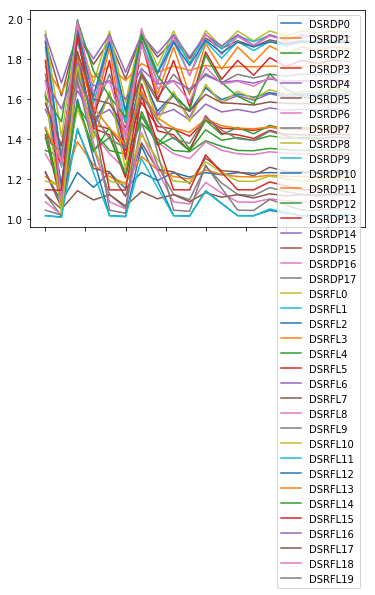

In [325]:
df_final.T.plot.line()

In [39]:
df_final

,actual0,lower0,upper0,best_estimate0,actual1,lower1,upper1,best_estimate1,actual2,lower2,upper2,best_estimate2,actual3,lower3,upper3,best_estimate3,actual4,lower4,upper4,best_estimate4
DSRDP0,1.424449,1.133127,1.986740,1.559933,1.424449,1.264822,1.732551,1.498687,1.424449,1.376523,1.516954,1.446738,1.424449,1.416565,1.439667,1.428116,1.424449,1.423738,1.425821,1.424780
DSRDP1,1.643277,1.361325,1.929198,1.645262,1.643277,1.480942,1.807897,1.644419,1.643277,1.589464,1.697847,1.643655,1.643277,1.633006,1.653692,1.643349,1.643277,1.642148,1.644421,1.643285
DSRDP2,1.673795,1.647696,1.886722,1.767209,1.673795,1.659526,1.790205,1.724866,1.673795,1.669530,1.708589,1.689060,1.673795,1.673098,1.679481,1.676290,1.673795,1.673733,1.674303,1.674018
DSRDP3,1.291863,1.060695,1.376920,1.218808,1.291863,1.148861,1.344480,1.246671,1.291863,1.237140,1.311998,1.274569,1.291863,1.278908,1.296629,1.287769,1.291863,1.289966,1.292561,1.291263
DSRDP4,1.009784,1.008901,1.920328,1.464614,1.009784,1.009322,1.486136,1.247729,1.009784,1.009657,1.140155,1.074906,1.009784,1.009766,1.028450,1.019108,1.009784,1.009782,1.011182,1.010482
DSRDP5,1.074826,1.062191,1.205479,1.133835,1.074826,1.067024,1.155504,1.111264,1.074826,1.071851,1.105589,1.088720,1.074826,1.074125,1.082069,1.078097,1.074826,1.074724,1.075879,1.075301
DSRDP6,1.222652,1.066293,1.683133,1.374713,1.222652,1.139776,1.466724,1.303250,1.222652,1.199369,1.291221,1.245295,1.222652,1.219185,1.232863,1.226024,1.222652,1.222379,1.223458,1.222918
DSRDP7,1.033501,1.001570,1.780507,1.391038,1.033501,1.015601,1.452255,1.233928,1.033501,1.027876,1.165093,1.096484,1.033501,1.032510,1.056682,1.044596,1.033501,1.033403,1.035790,1.034596
DSRDP8,1.787848,1.695486,1.911284,1.803385,1.787848,1.722933,1.874603,1.798768,1.787848,1.755781,1.830704,1.793242,1.787848,1.776715,1.802727,1.789721,1.787848,1.785131,1.791479,1.788305
DSRDP9,1.645249,1.237023,1.678542,1.457782,1.645249,1.413076,1.664184,1.538630,1.645249,1.570150,1.651374,1.610762,1.645249,1.631434,1.646376,1.638905,1.645249,1.643804,1.645367,1.644585


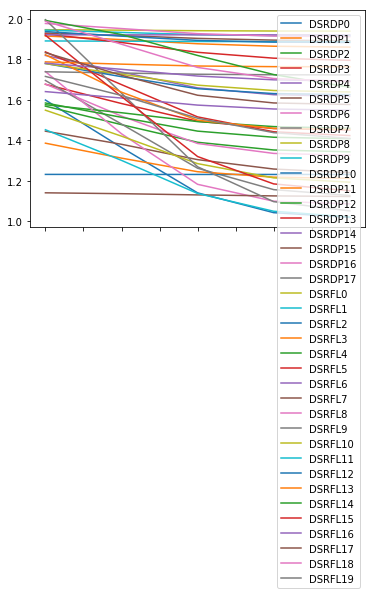

In [327]:
pd.DataFrame({"name{}".format(i):df['upper'] for i,df in enumerate(testdfs)}).T.plot()

In [257]:
global_dfs_var_unc_data['p0n0']

,actual,lower,upper,best_estimate
DSRDP0,1.015003,1.008658,1.598299,1.303479
DSRDP1,1.858495,1.106396,1.914770,1.510583
DSRDP2,1.341087,1.310102,1.567980,1.439041
DSRDP3,1.448467,1.265519,1.675949,1.470734
DSRDP4,1.615594,1.094348,1.818576,1.456462
DSRDP5,1.890072,1.614069,1.929471,1.771770
DSRDP6,1.324616,1.179957,1.677272,1.428614
DSRDP7,1.121350,1.012851,1.694784,1.353817
DSRDP8,1.938678,1.409590,1.945943,1.677767
DSRDP9,1.915348,1.278802,1.943758,1.611280


In [229]:
label

'p0n0p1n1p2n4p3n13p4n40'

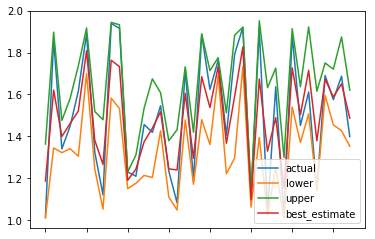

In [59]:
global_dfs_var_unc_data['p0n0p1n2'].plot()#kind='bar')

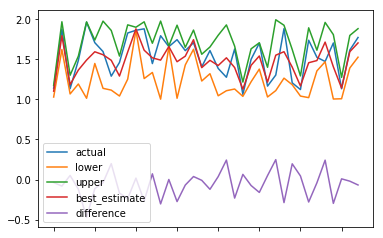

In [124]:
df_test.plot()

#### test functions 

# check for size of dictionary and its items

In [34]:
from __future__ import print_function
from sys import getsizeof, stderr
from itertools import chain
from collections import deque
try:
    from reprlib import repr
except ImportError:
    pass

def total_size(o, handlers={}, verbose=False):
    """ Returns the approximate memory footprint an object and all of its contents.

    Automatically finds the contents of the following builtin containers and
    their subclasses:  tuple, list, deque, dict, set and frozenset.
    To search other containers, add handlers to iterate over their contents:

        handlers = {SomeContainerClass: iter,
                    OtherContainerClass: OtherContainerClass.get_elements}

    """
    dict_handler = lambda d: chain.from_iterable(d.items())
    all_handlers = {tuple: iter,
                    list: iter,
                    deque: iter,
                    dict: dict_handler,
                    set: iter,
                    frozenset: iter,
                   }
    all_handlers.update(handlers)     # user handlers take precedence
    seen = set()                      # track which object id's have already been seen
    default_size = getsizeof(0)       # estimate sizeof object without __sizeof__

    def sizeof(o):
        if id(o) in seen:       # do not double count the same object
            return 0
        seen.add(id(o))
        s = getsizeof(o, default_size)

        if verbose:
            print(s, type(o), repr(o), file=stderr)

        for typ, handler in all_handlers.items():
            if isinstance(o, typ):
                s += sum(map(sizeof, handler(o)))
                break
        return s

    return sizeof(o)


# ##### Example call #####

# if __name__ == '__main__':
#     d = dict(a=1, b=2, c=3, d=[4,5,6,7], e='a string of chars')
#     print(total_size(d, verbose=True))

In [47]:
print(total_size(global_dfs_var_unc_data, verbose=True))

4704 <class 'dict'> {'p0n0':            ac...      1.524229, 'p0n0p1n1':            ac...      1.487009, 'p0n0p1n1p2n4':            ac...      1.442561, 'p0n0p1n1p2n4p3n13':            ac...      1.414339, ...}
53 <class 'str'> 'p0n0'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.524229
57 <class 'str'> 'p0n0p1n1'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.487009
57 <class 'str'> 'p0n0p1n2'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.487009
57 <class 'str'> 'p0n0p1n3'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.487009
61 <class 'str'> 'p0n0p1n1p2n4'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.442561
61 <class 'str'> 'p0n0p1n1p2n5'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.442561
61 <class 'str'> 'p0n0p1n1p2n6'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.442561
61 <class 'str'> 'p0n0p1n2p2n7'
4220 <class 'pandas.core.frame.Data

472179


 <class 'pandas.core.frame.DataFrame'>            ac...      1.403051
73 <class 'str'> 'p0n0p1n3p2n12p3n39p4n107'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.403051
73 <class 'str'> 'p0n0p1n3p2n12p3n39p4n108'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.403051


In [35]:
print(total_size(global_dfs_var_unc_data, verbose=True))

18528 <class 'dict'> {'p0n0':            ac...      1.622947, 'p0n0p1n1':            ac...      1.607807, 'p0n0p1n1p2n6':            ac...      1.588514, 'p0n0p1n1p2n6p3n28':            ac...      1.574864, ...}
53 <class 'str'> 'p0n0'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.622947
57 <class 'str'> 'p0n0p1n1'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.607807
57 <class 'str'> 'p0n0p1n2'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.607807
57 <class 'str'> 'p0n0p1n3'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.607807
57 <class 'str'> 'p0n0p1n4'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.607807
57 <class 'str'> 'p0n0p1n5'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.607807
61 <class 'str'> 'p0n0p1n1p2n6'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.588514
61 <class 'str'> 'p0n0p1n1p2n7'
5564 <class 'pandas.core.frame.DataFrame'>

5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.574864
67 <class 'str'> 'p0n0p1n3p2n18p3n87'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.574864
67 <class 'str'> 'p0n0p1n3p2n18p3n88'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.574864
67 <class 'str'> 'p0n0p1n4p2n19p3n89'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.574864
67 <class 'str'> 'p0n0p1n4p2n19p3n90'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.574864
67 <class 'str'> 'p0n0p1n4p2n19p3n91'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.574864
67 <class 'str'> 'p0n0p1n4p2n19p3n92'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.574864
67 <class 'str'> 'p0n0p1n4p2n19p3n93'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.574864
67 <class 'str'> 'p0n0p1n4p2n19p3n94'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.574864
67 <class 'str'> 'p0n0p1n4p2n2

5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
72 <class 'str'> 'p0n0p1n1p2n8p3n40p4n178'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
72 <class 'str'> 'p0n0p1n1p2n8p3n40p4n179'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
72 <class 'str'> 'p0n0p1n1p2n8p3n40p4n180'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
72 <class 'str'> 'p0n0p1n1p2n8p3n41p4n181'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
72 <class 'str'> 'p0n0p1n1p2n8p3n41p4n182'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
72 <class 'str'> 'p0n0p1n1p2n8p3n41p4n183'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
72 <class 'str'> 'p0n0p1n1p2n8p3n41p4n184'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
72 <class 'str'> 'p0n0p1n1p2n8p3n41p4n185'
5564 <class 'pandas.core.frame.DataFrame'>            ac...     

5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n14p3n65p4n271'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n14p3n65p4n272'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n14p3n65p4n273'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n14p3n65p4n274'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n14p3n65p4n275'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n14p3n65p4n276'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n14p3n66p4n277'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n14p3n66p4n278'
5564 <class 'pandas.core.frame.DataFrame'>            ac

5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n18p3n86p4n374'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n18p3n86p4n375'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n18p3n87p4n376'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n18p3n87p4n377'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n18p3n87p4n378'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n18p3n87p4n379'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n18p3n88p4n380'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
73 <class 'str'> 'p0n0p1n3p2n18p3n88p4n381'
5564 <class 'pandas.core.frame.DataFrame'>            ac

5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n4p2n22p3n107p4n469'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n4p2n22p3n108p4n470'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n4p2n22p3n108p4n471'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n4p2n22p3n108p4n472'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n4p2n22p3n108p4n473'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n4p2n23p3n109p4n474'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n4p2n23p3n109p4n475'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n4p2n23p3n109p4n476'
5564 <class 'pandas.core.frame.DataFrame'>      

5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n4p2n24p3n121p4n540'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n25p3n122p4n541'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n25p3n122p4n542'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n25p3n122p4n543'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n25p3n123p4n544'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n25p3n123p4n545'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n25p3n123p4n546'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n25p3n124p4n547'
5564 <class 'pandas.core.frame.DataFrame'>      

3382939


 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n26p3n130p4n568'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n27p3n131p4n569'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n27p3n131p4n570'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n27p3n131p4n571'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n27p3n131p4n572'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n27p3n131p4n573'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n27p3n132p4n574'
5564 <class 'pandas.core.frame.DataFrame'>            ac...      1.568509
74 <class 'str'> 'p0n0p1n5p2n27p3n132p4n575'
5564 <class 'pandas.core.frame.DataFrame'>          